# Adult Income: Exploratory Analysis and Predictions

This notebook has been created to help you go through the steps of a Machine Learning project Life-Cicle, from Business Understanding to presenting the final result to the Business.

In [148]:
import requests
import os
# Preprocessing/Visualization libraries
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns 
import matplotlib.pyplot as plt

# Model libraries
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
def aquire_data(path_to_data, data_urls):
    if not os.path.exists(path_to_data):
        os.mkdir(path_to_data)
        
    for url in data_urls:
        data = requests.get(url).content
        filename = os.path.join(path_to_data, os.path.basename(url))
        with open(filename, 'wb') as file: 
            file.write(data)

In [4]:
data_urls = ["https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
             "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
             "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

aquire_data('data', data_urls)

UCI website:

- adult.names: which corresponds to the different column names
- adult.data: corresponds to all the observations in the training data.
- data.test: corresponds to all the observation in the test data

In [5]:
column_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", 
                "Martial Status", "Occupation", "Relationship", "Race", "Sex", 
                "Capital-Gain", "Capital-Loss", "Hours-per-week", "Country", "Income"] 

Here we are going to acquire the training and the test datasets. The corresponding column names have been specified in the previous column_names variable. Then, we use the regular expression ' *, *' to trim all the whitespaces we can encounter in our datasets. As all the missing values have been specificied by ?, so, na_values is used to take them into consideration during the data loading. Finally we specify engine='python' to avoid the warning that comes after using regular expression syntax.

In [7]:
train = pd.read_csv('data/adult.data', names=column_names, sep=' *, *', na_values='?', 
                   engine='python')
test = pd.read_csv('data/adult.test', names=column_names, sep=' *, *', skiprows=1, 
                   engine='python', na_values='?')

In [8]:
test.Income.unique() 

array(['<=50K.', '>50K.'], dtype=object)

In [9]:
train.Income.unique()

array(['<=50K', '>50K'], dtype=object)

In [12]:
# Transform the Income column value for test data, in order to remove the "." at the end
test.Income = np.where(test.Income == '<=50K.', '<=50K', '>50K')

# Concat both datasets 
df = pd.concat((train, test), axis=0)

# First 5 observations
df.head()

Age         Workclass  fnlwgt  Education  Education-Num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       Martial Status         Occupation   Relationship   Race     Sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   Capital-Gain  Capital-Loss  Hours-per-week        Country Income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [13]:
print('Our data contains {} observations and {} columns.'.format(df.shape[0],
                                                                df.shape[1]))

Our data contains 48842 observations and 15 columns.


## Data Munging 

For this part we will do to main things

- Missing values
- Outliners

### Missing values

For this part, there are many ways do deal with missing values, we could eliminate those missing values, but we want to work with more data not less. So we will use the next techniques:
- Replace missing data of categorical columns data with the mode value (most occuring category) of that column.
- Replace missing numerical columns data with the median value of that column. Here we could use the mean instead of median, but the mean is very prompt to outliers (extreme values).

In [14]:
print(df.isnull().sum())

Age                  0
Workclass         2799
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital-Gain         0
Capital-Loss         0
Hours-per-week       0
Country            857
Income               0
dtype: int64


To the left, we have the name of the features and the number of missing values to the right. We can see that:

- Workclass has 1836 missing values
- Occupation has 1843 missing values
- Country has 583 missing values

In [15]:
print(df.dtypes)

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education-Num      int64
Martial Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
Income            object
dtype: object


In [18]:
# Workclass
print('Number of missing values: {}'.format(len(df['Workclass'].unique())))
print(df['Workclass'].unique())

# Occupation
print('Number of missing values: {}'.format(len(df['Occupation'].unique())))
print(df['Occupation'].unique())

# Country
print('Number of missing values: {}'.format(len(df['Country'].unique())))
print(df['Country'].unique())

Number of missing values: 9
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Number of missing values: 15
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
Number of missing values: 42
['United-States' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands']


In [21]:
def fill_categorical_missing(data, column):
    data.loc[data[column].isnull(), column] = stat.mode(data[column])

cols_to_fill = ['Workclass', 'Occupation', 'Country']

for col in cols_to_fill:
    fill_categorical_missing(df, col)

print(df.isnull().sum())

Age               0
Workclass         0
fnlwgt            0
Education         0
Education-Num     0
Martial Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital-Gain      0
Capital-Loss      0
Hours-per-week    0
Country           0
Income            0
dtype: int64


### Outliers

To be able to identify outliers in our dataset, we will use seaborn boxplot to all our numerical columns, and show the final result with matplotlib's show() function.

In [23]:
df_ol = df.copy()
df_ol.describe()

Age        fnlwgt  Education-Num  Capital-Gain  Capital-Loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       Hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

We're examining a dataset containing six numerical columns, ranging from Age to Hours-per-week. Alongside each column, we've compiled several statistical metrics:

- Count: Reflects the total number of observations in each column.
- Mean: Represents the average value of each column.
- Standard deviation (std): Indicates the dispersion of values around the mean.
- Quantiles (25%, 50%, 75%): These denote specific points in the data distribution. For instance, the 25th percentile (25%) signifies the value below which 25% of the data falls, and so forth.

By utilizing the quantiles, along with the minimum and maximum values, we categorize the dataset into four distinct segments:

- Segment 1: Encompasses values falling below the 25th percentile. For example, in the Age column, this would indicate that 25% of individuals are under 28 years old.
- Segment 2: Represents values between the 25th and 50th percentiles. In the Age column, this would signify individuals aged between 28 and 37 years old.
- Segment 3: Covers values between the 50th and 75th percentiles, indicating individuals aged between 37 and 48 years old in the Age column.
- Segment 4: Encompasses values exceeding the 75th percentile, indicating individuals over 48 years old in the Age column.

Additionally, we identify outliers by considering values beyond 1.5 times the Interquartile Range (IQR). The IQR, calculated as the difference between the 75th and 25th percentiles, provides a measure of data spread and is used to detect values significantly divergent from the norm.

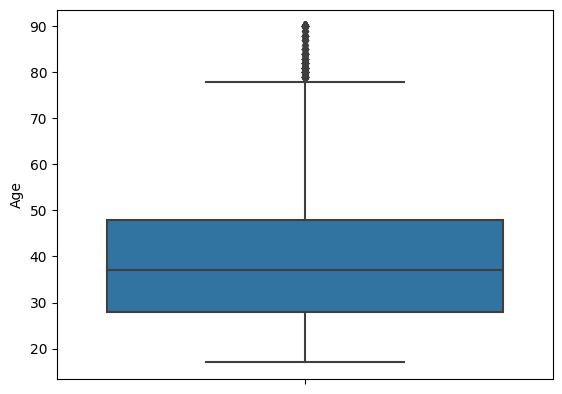

In [28]:
# Age
sns.boxplot(y='Age', data=df_ol)
plt.show()

In [31]:
def ten_to_ten_percentiles(data, column):
    for i in range(0,100,10):
        var = data[column].values
        var = np.sort(var, axis=None)
        print('{} percentile value is {}'.format(i, var[int(len(var) * (float(i)/100))]))
    print('100 percentile value is {}'.format(var[-1]))

def percentiles_from_90(data, column):
    for i in range(90,100):
        var = data[column].values
        var = np.sort(var, axis=None)
        print('{} percentile value is {}'.format(i, var[int(len(var) * (float(i)/100))]))
    print('100 percentile value is {}'.format(var[-1]))

def percentiles_from_99(data, column):
    for i in np.arange(0.0, 1.0, 0.1):
        var =data[column].values
        var = np.sort(var,axis = None)
        print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
    print("100 percentile value is ",var[-1])

In [30]:
ten_to_ten_percentiles(df_ol, 'Age')

0 percentile value is 17
10 percentile value is 22
20 percentile value is 26
30 percentile value is 30
40 percentile value is 33
50 percentile value is 37
60 percentile value is 41
70 percentile value is 45
80 percentile value is 51
90 percentile value is 58
100 percentile value is 90


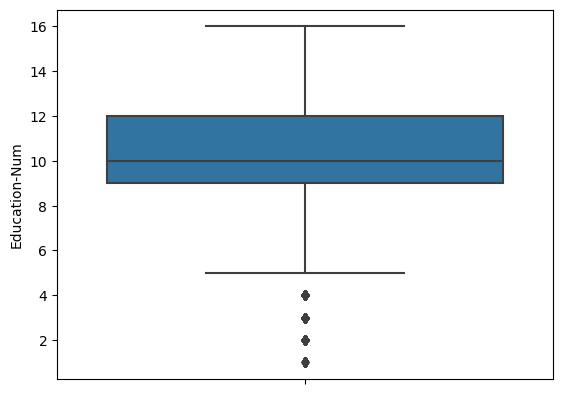

In [32]:
sns.boxplot(y='Education-Num', data=df_ol)
plt.show()

In [33]:
ten_to_ten_percentiles(df_ol, 'Education-Num')

0 percentile value is 1
10 percentile value is 7
20 percentile value is 9
30 percentile value is 9
40 percentile value is 9
50 percentile value is 10
60 percentile value is 10
70 percentile value is 11
80 percentile value is 13
90 percentile value is 13
100 percentile value is 16


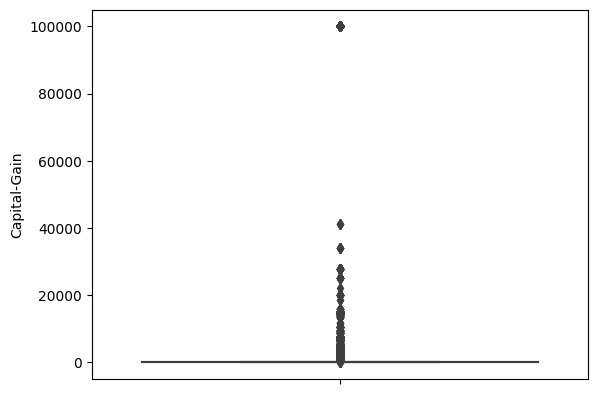

In [35]:
sns.boxplot(y='Capital-Gain', data=df_ol)
plt.show()

In [37]:
ten_to_ten_percentiles(df_ol, 'Capital-Gain')

0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 0
70 percentile value is 0
80 percentile value is 0
90 percentile value is 0
100 percentile value is 99999


In [39]:
percentiles_from_90(df_ol, 'Capital-Gain')

90 percentile value is 0
91 percentile value is 0
92 percentile value is 1151
93 percentile value is 2829
94 percentile value is 3674
95 percentile value is 5013
96 percentile value is 7298
97 percentile value is 7688
98 percentile value is 14084
99 percentile value is 15024
100 percentile value is 99999


In [41]:
percentiles_from_99(df_ol, 'Capital-Gain')

99.0 percentile value is 15024
99.1 percentile value is 15024
99.2 percentile value is 15831
99.3 percentile value is 20051
99.4 percentile value is 27828
99.5 percentile value is 41310
99.6 percentile value is 99999
99.7 percentile value is 99999
99.8 percentile value is 99999
99.9 percentile value is 99999
100 percentile value is  99999


In [42]:
# Removing the outliers based on 99.5th percentile of Capital-Gain
df_cp = df_ol[df_ol['Capital-Gain']<=34095]

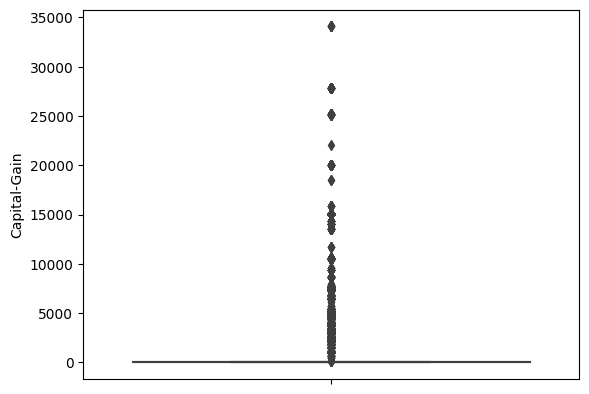

In [43]:
sns.boxplot(y='Capital-Gain', data=df_cp)
plt.show()

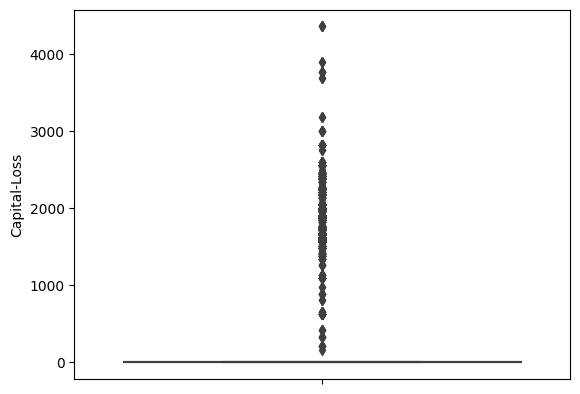

In [44]:
sns.boxplot(y='Capital-Loss', data=df_cp)
plt.show()

In [45]:
ten_to_ten_percentiles(df_cp, 'Capital-Loss')

0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 0
70 percentile value is 0
80 percentile value is 0
90 percentile value is 0
100 percentile value is 4356


In [46]:
percentiles_from_90(df_cp, 'Capital-Loss')

90 percentile value is 0
91 percentile value is 0
92 percentile value is 0
93 percentile value is 0
94 percentile value is 0
95 percentile value is 0
96 percentile value is 1590
97 percentile value is 1848
98 percentile value is 1902
99 percentile value is 2001
100 percentile value is 4356


In [47]:
percentiles_from_99(df_cp, 'Capital-Loss')

99.0 percentile value is 2001
99.1 percentile value is 2002
99.2 percentile value is 2051
99.3 percentile value is 2179
99.4 percentile value is 2231
99.5 percentile value is 2258
99.6 percentile value is 2377
99.7 percentile value is 2415
99.8 percentile value is 2415
99.9 percentile value is 2559
100 percentile value is  4356


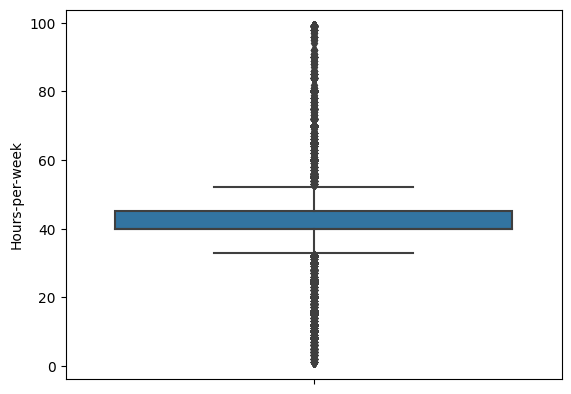

In [48]:
sns.boxplot(y='Hours-per-week', data=df_cp)
plt.show()

In [49]:
ten_to_ten_percentiles(df_cp, 'Hours-per-week')

0 percentile value is 1
10 percentile value is 24
20 percentile value is 35
30 percentile value is 40
40 percentile value is 40
50 percentile value is 40
60 percentile value is 40
70 percentile value is 40
80 percentile value is 48
90 percentile value is 55
100 percentile value is 99


In [50]:
def remove_outliers(data):
    a = data.shape[0]
    print("Number of salary records = {}".format(a))
        
    temp_data = data[data['Capital-Gain']<=34095]
    b = temp_data.shape[0]
    
    print('Number of outliers from the Capital-Gain column= {}'.format(a - b))
        
    data = data[(data['Capital-Gain']<=34095)]
    
    print('Total outlies removed = {}'.format(a-b))
    print('-----'*10)
    return data

In [51]:
print('Removing all the outliers from the data')
print('-----'*10)
df_no_outliers = remove_outliers(df)

proportion_remaing_data = float(len(df_no_outliers)) / len(df)
print('Proportion of observation that remain after removing outliers = {}'.format(proportion_remaing_data))

Removing all the outliers from the data
--------------------------------------------------
Number of salary records = 48842
Number of outliers from the Capital-Gain column= 247
Total outlies removed = 247
--------------------------------------------------
Proportion of observation that remain after removing outliers = 0.9949428770320625


## EDA

In [52]:
df_no_outliers.Income.unique()

array(['<=50K', '>50K'], dtype=object)

<AxesSubplot: xlabel='Income', ylabel='count'>

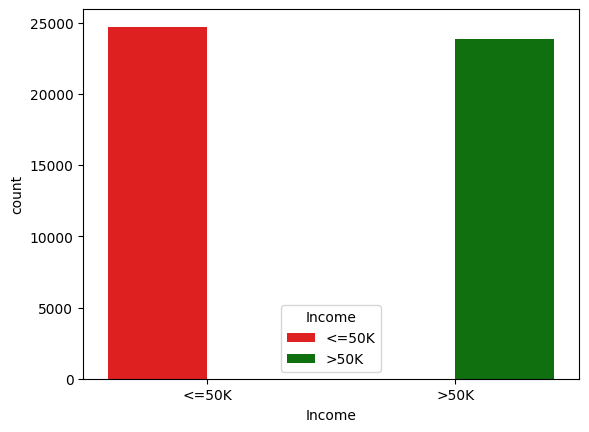

In [53]:
palette = {"<=50K":"r", ">50K":"g"}
sns.countplot(x="Income", data=df_no_outliers, hue="Income", palette=palette)

In [54]:
df_no_outliers.describe()

Age        fnlwgt  Education-Num  Capital-Gain  Capital-Loss  \
count  48595.000000  4.859500e+04   48595.000000  48595.000000  48595.000000   
mean      38.603375  1.896813e+05      10.063422    579.897829     87.947073   
std       13.712317  1.056323e+05       2.562615   2516.463352    403.979066   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175490e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.782070e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.377130e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  34095.000000   4356.000000   

       Hours-per-week  
count    48595.000000  
mean        40.371026  
std         12.367802  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

<AxesSubplot: title={'center': 'Density plot for Age'}, ylabel='Density'>

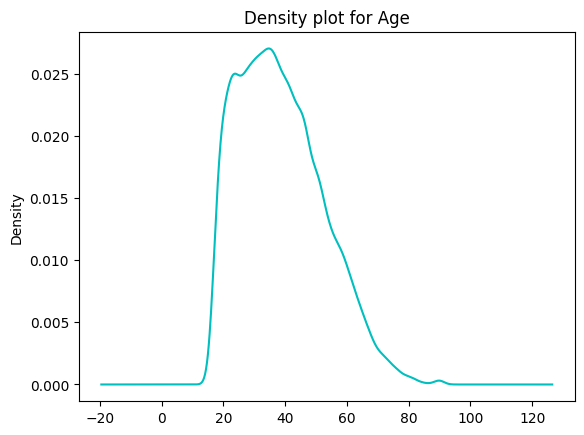

In [55]:
df_no_outliers.Age.plot(kind='kde', title='Density plot for Age', color='c')

Here, we have a positive skewed distribution for Age feature.

<AxesSubplot: title={'center': 'Density plot for Capital-Gain'}, ylabel='Density'>

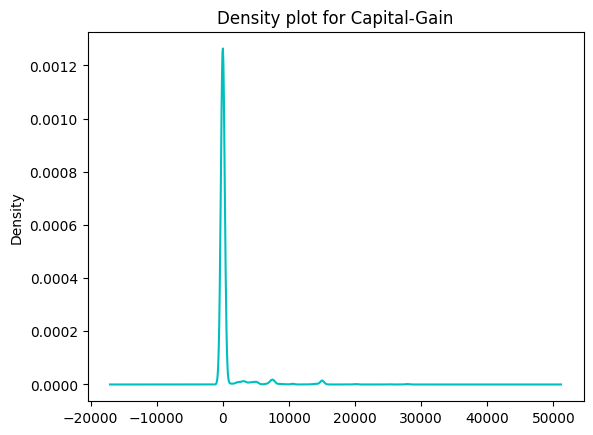

In [57]:
df_no_outliers['Capital-Gain'].plot(kind='kde', title='Density plot for Capital-Gain', color='c')

<AxesSubplot: title={'center': 'Density plot for Capital-Loss'}, ylabel='Density'>

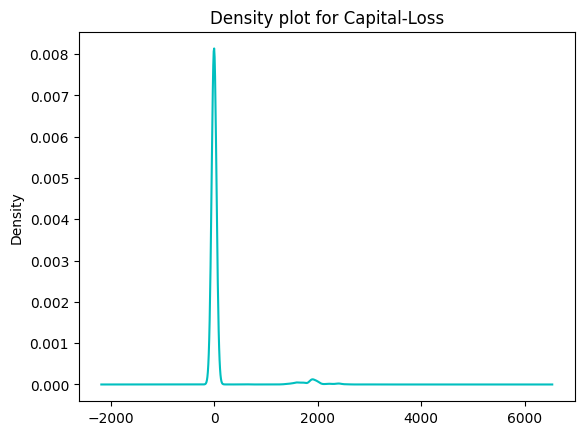

In [58]:
df_no_outliers['Capital-Loss'].plot(kind='kde', title='Density plot for Capital-Loss', color='c')

<AxesSubplot: title={'center': 'Density plot for Hours-per-week'}, ylabel='Density'>

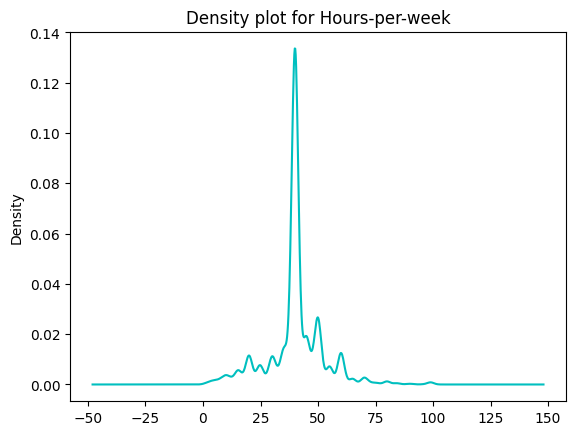

In [59]:
df_no_outliers['Hours-per-week'].plot(kind='kde', title='Density plot for Hours-per-week', color='c')

We need to deal with the problem of distribution for all our numerical data values in the feature engineering part.

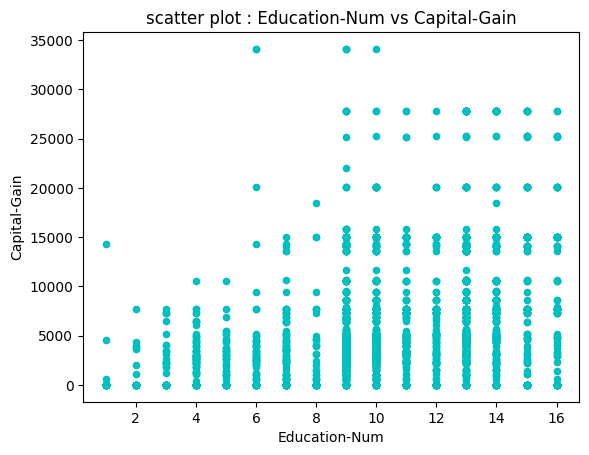

In [60]:
df_no_outliers.plot.scatter(x='Education-Num', y='Capital-Gain', color='c', title='scatter plot : Education-Num vs Capital-Gain');

We have a positive relationship between the number of year of education and the Capital Gain. The more educated you are, your are likely to have more capital.

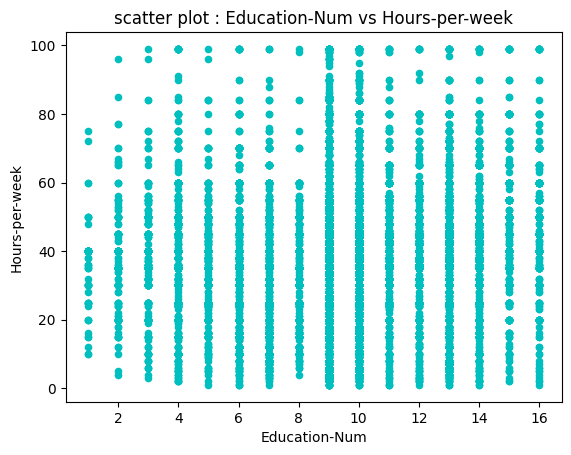

In [61]:
df_no_outliers.plot.scatter(x='Education-Num', y='Hours-per-week', color='c', title='scatter plot : Education-Num vs Hours-per-week');

We cannot see any type of patterns

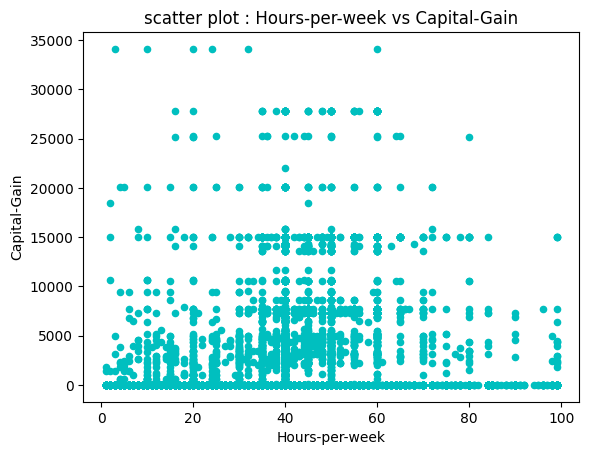

In [62]:
df_no_outliers.plot.scatter(x='Hours-per-week', y='Capital-Gain', color='c', title='scatter plot : Hours-per-week vs Capital-Gain');

Same with this one, no interesting patterns

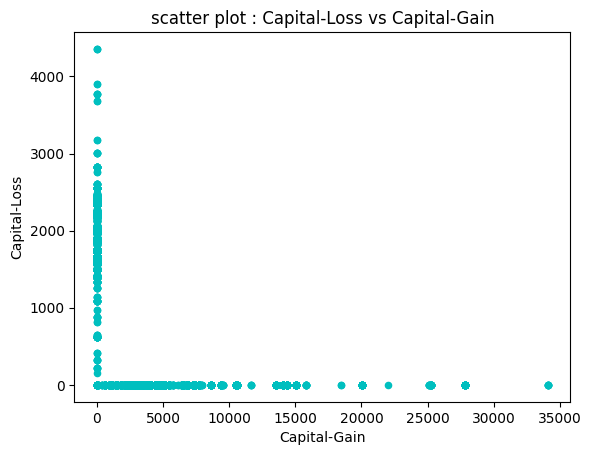

In [63]:
df_no_outliers.plot.scatter(x='Capital-Gain', y='Capital-Loss', color='c', title='scatter plot : Capital-Loss vs Capital-Gain');

People without any capital Gain lose a lot of money, which is obvious, because without any capital Gain, you would need to borrow with interest, and then keep "surviving".

<AxesSubplot: >

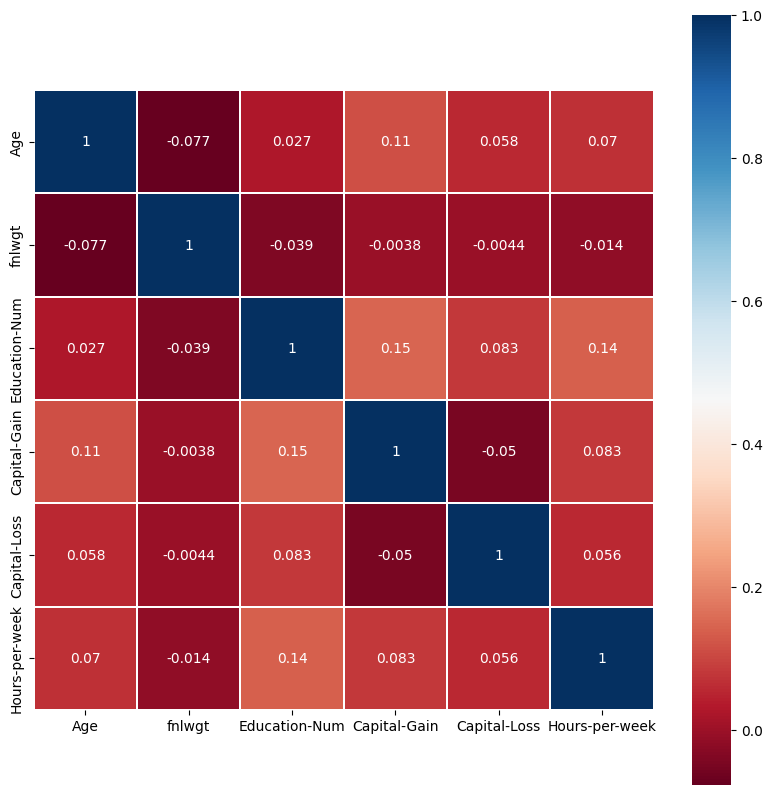

In [64]:
numerical_cols = ['int64']  
plt.figure(figsize=(10, 10))
sns.heatmap( 
            df_no_outliers.select_dtypes(include=numerical_cols).corr(),
            cmap=plt.cm.RdBu, 
            vmax=1.0,
            linewidths=0.1,
            linecolor='white', 
            square=True,
            annot=True
)

From the correlation matrix, we can see that the level of relationship is very low between the numerical features.

Now lets see the categorical variables

In [65]:
df_no_outliers['Country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico', 'South',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

We can see a clear error here with the "Country" south, that we know is not a country, we will fix that now

In [66]:
south_df = df_no_outliers[df_no_outliers['Country']=='South']
a = south_df.shape[0]
b = df_no_outliers.shape[0]

print('{} rows corresponds to South, which represents {}% of the data'.format(a, (1.0*a/b)*100))

113 rows corresponds to South, which represents 0.2325342113386151% of the data


We can remove all the corresponding rows for Country == South because, it corresponds to only 0.244% of the original dataset.

In [67]:
south_index = south_df.index 
df_no_outliers.drop(south_index, inplace=True)

Now some changes for some names of the countries

In [68]:
df_no_outliers.loc[df_no_outliers['Country']=='Outlying-US(Guam-USVI-etc)', 'Country'] = 'Outlying-US'
df_no_outliers.loc[df_no_outliers['Country']=='Trinadad&Tobago', 'Country'] = 'Trinadad-Tobago'
df_no_outliers.loc[df_no_outliers['Country']=='Hong', 'Country'] = 'Hong-Kong'

For the next step lets separate them by their continent

In [69]:
asia = ['India', 'Iran', 'Philippines', 'Cambodia', 'Thailand', 'Laos', 'Taiwan', 
       'China', 'Japan', 'Vietnam', 'Hong-Kong']  

america = ['United-States', 'Cuba', 'Jamaica', 'Mexico', 'Puerto-Rico', 'Honduras', 
           'Canada', 'Columbia', 'Ecuador', 'Haiti', 'Dominican-Republic', 
           'El-Salvador', 'Guatemala', 'Peru', 'Outlying-US', 'Trinadad-Tobago', 
           'Nicaragua', '']  

europe = ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Yugoslavia', 
          'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands'] 

In [84]:
continents = {country: 'Asia' for country in asia}
continents.update({country: 'America' for country in america})
continents.update({country: 'Europe' for country in europe})

In [85]:
df_no_outliers['Continent'] = df_no_outliers['Country'].map(continents)
df_no_outliers['Country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru', 'Outlying-US', 'Scotland',
       'Trinadad-Tobago', 'Greece', 'Nicaragua', 'Vietnam', 'Hong-Kong',
       'Ireland', 'Hungary', 'Holand-Netherlands'], dtype=object)

In [98]:
def Occupation_VS_Income(continent, df):
    choice = df[df['Continent']==continent] 
    
    # Aggregate data by country and occupation
    country_occupation_income = choice.groupby(['Country', 'Occupation', 'Income']).size().unstack(fill_value=0)
    
    # Plot for each country
    for country in country_occupation_income.index.levels[0]:
        country_data = country_occupation_income.loc[country]
        country_data.plot(kind='bar', title='Income VS Occupation in {}'.format(country))
        plt.show()  # Display the plot


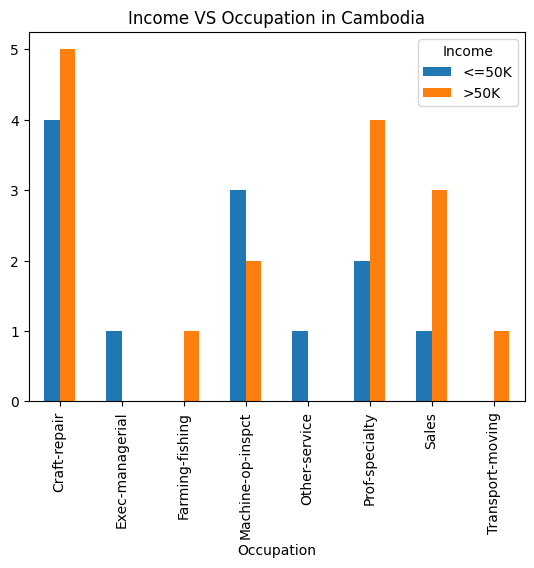

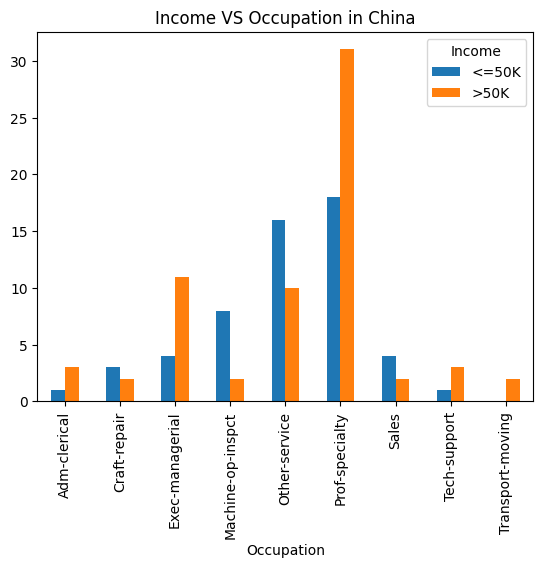

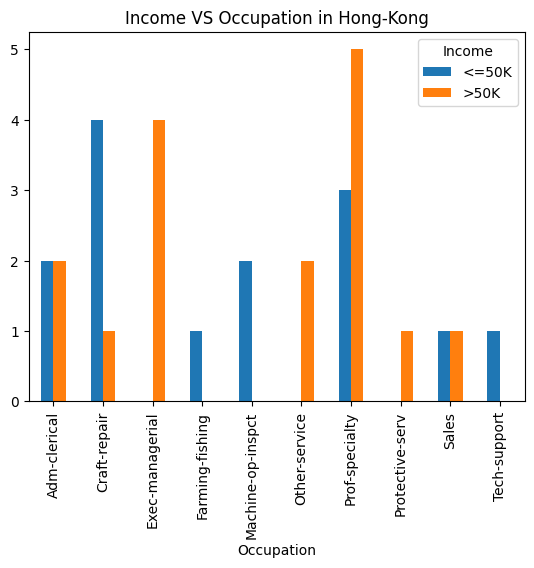

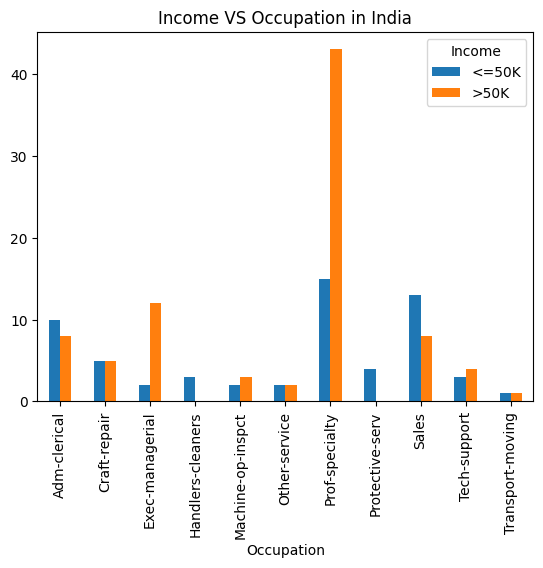

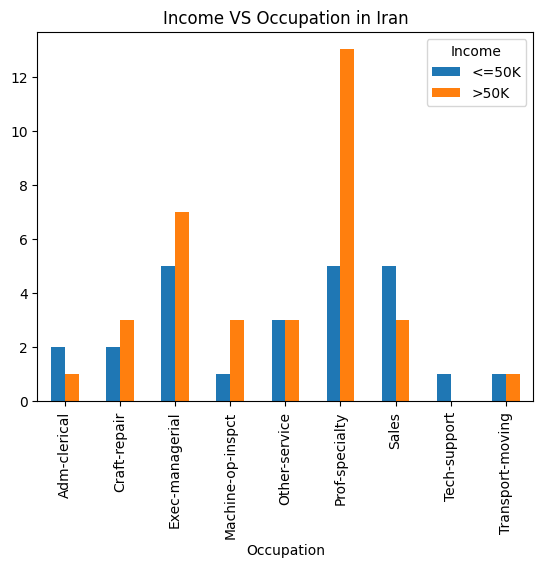

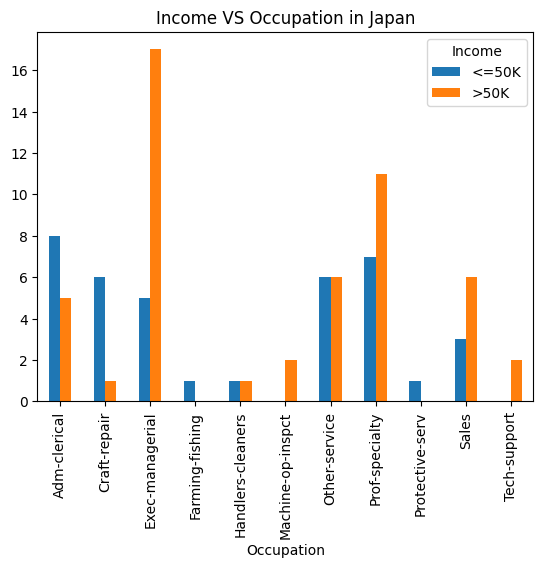

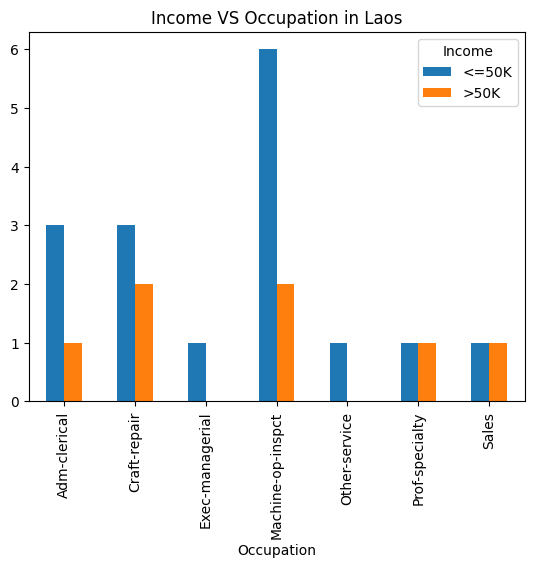

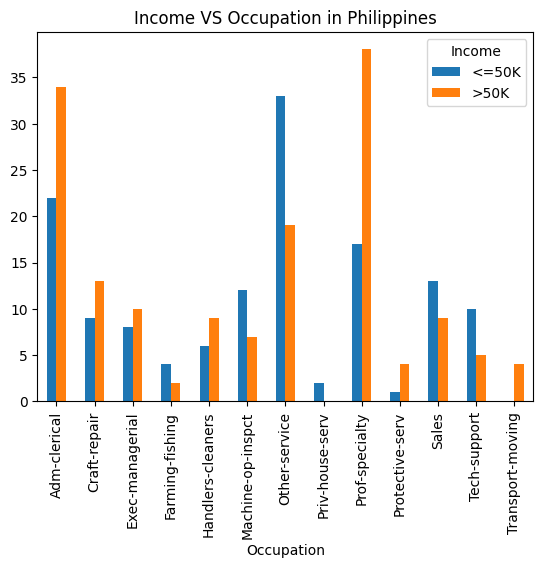

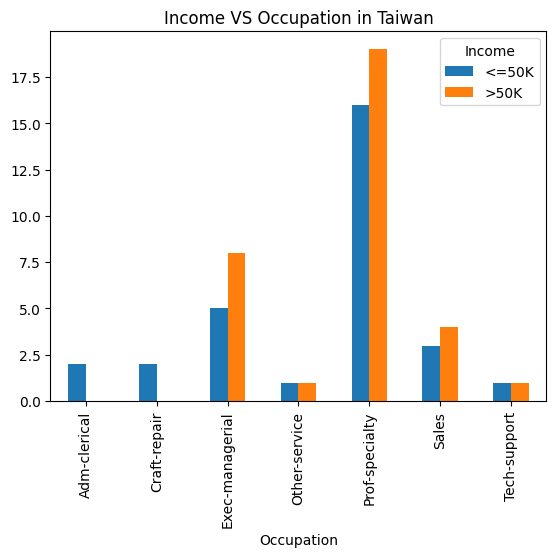

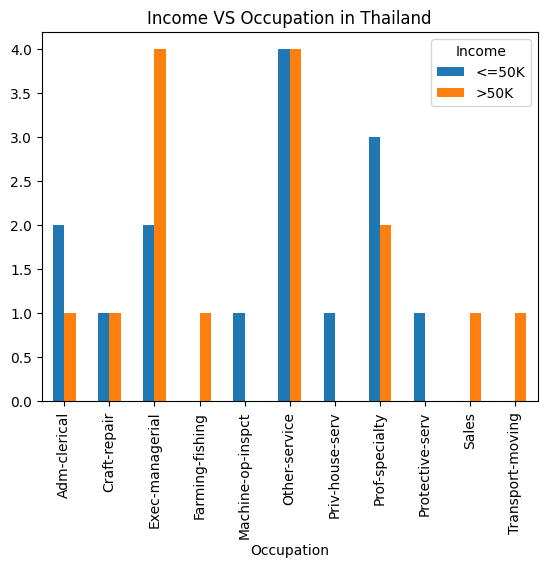

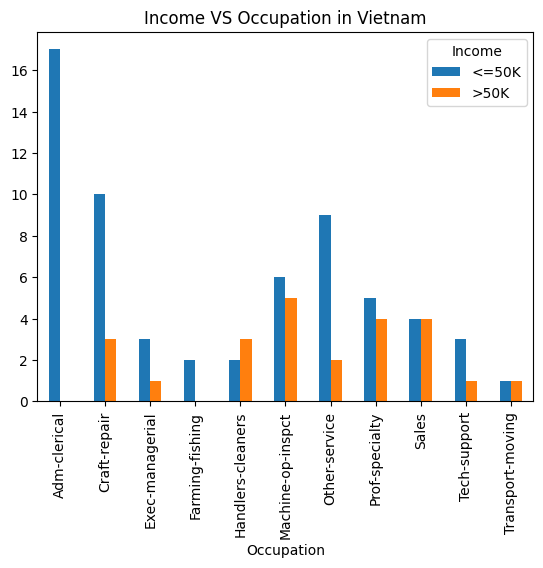

In [99]:
Occupation_VS_Income('Asia', df_no_outliers)

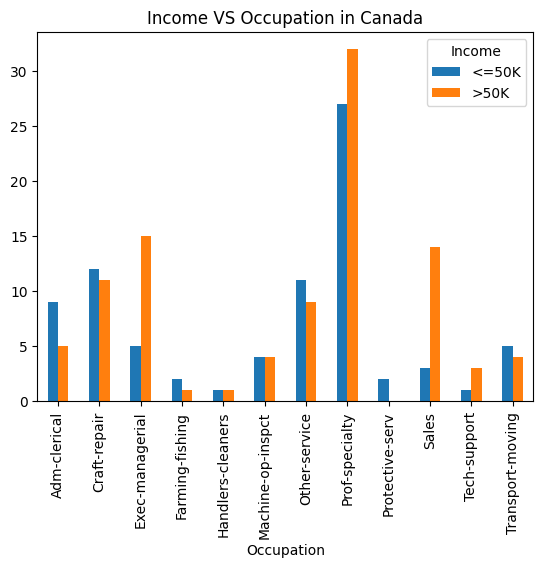

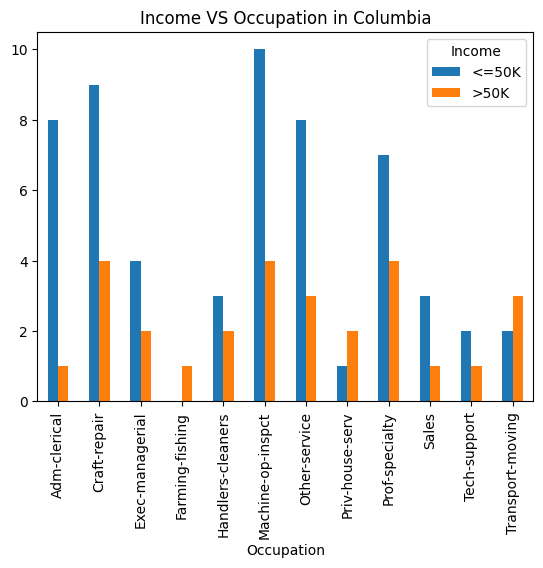

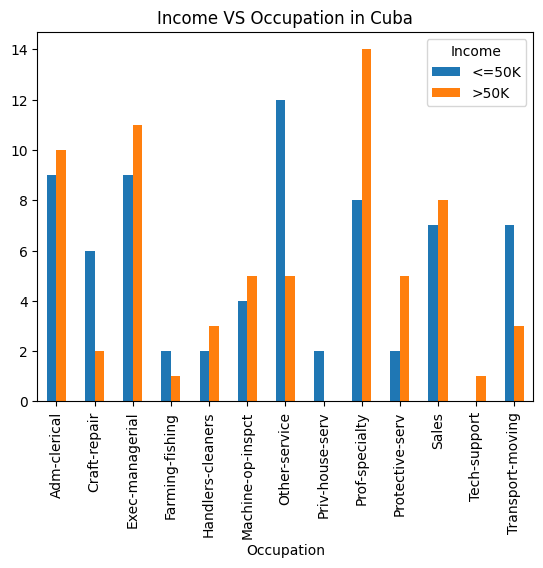

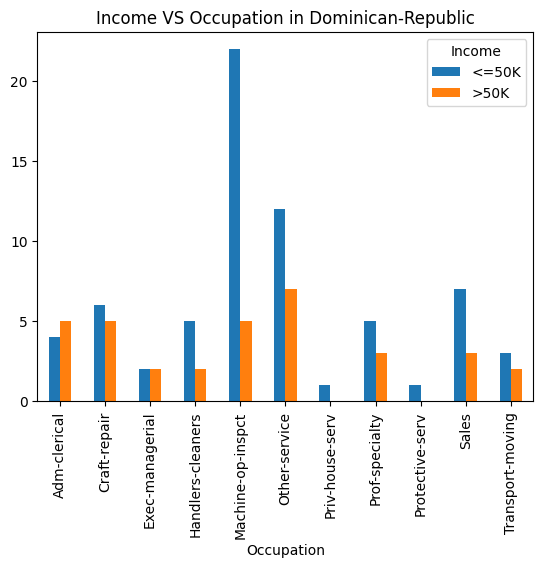

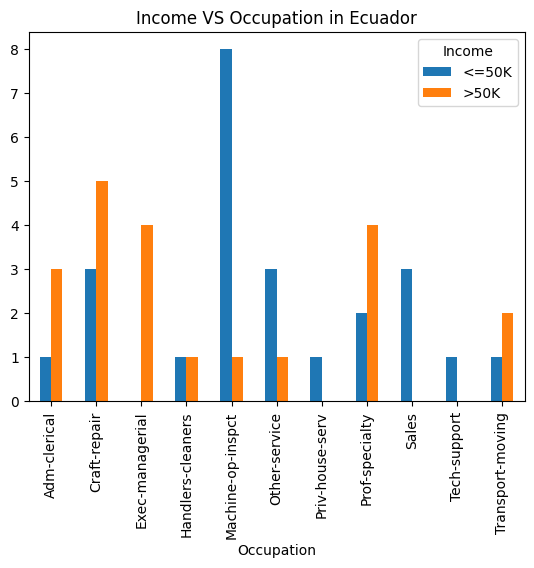

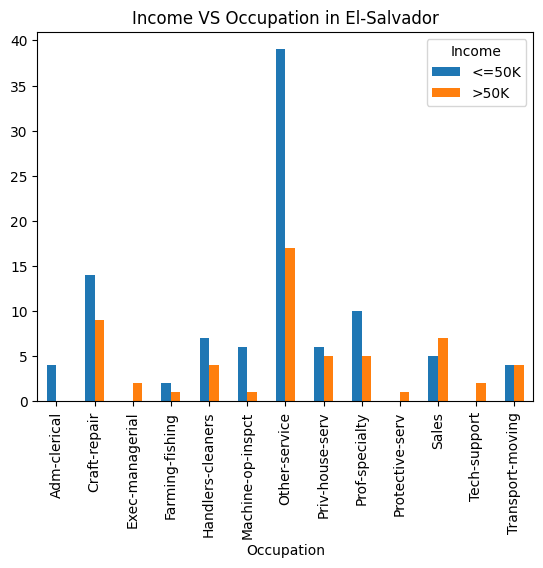

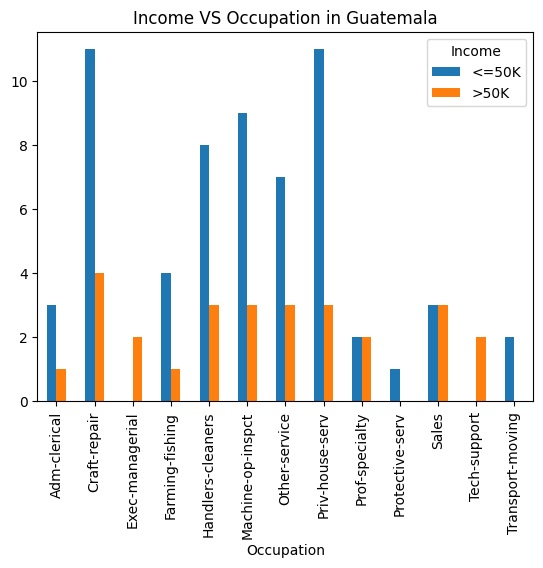

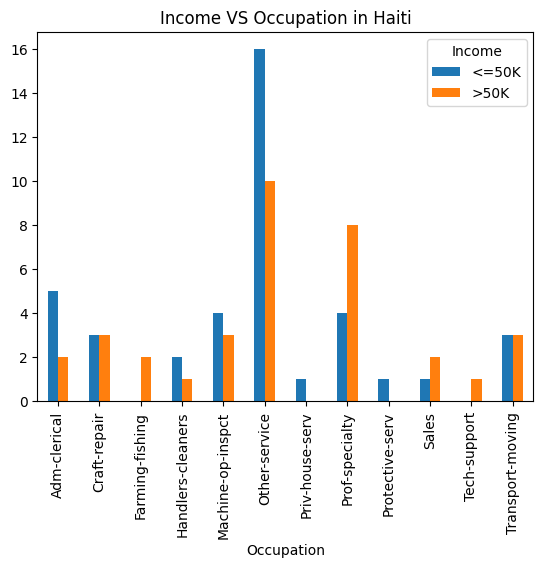

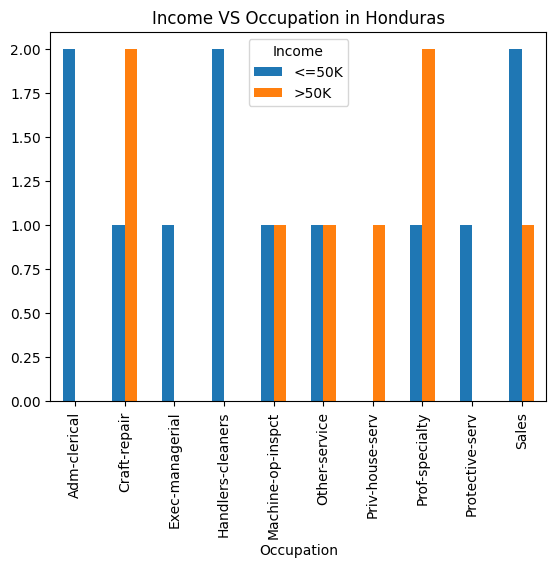

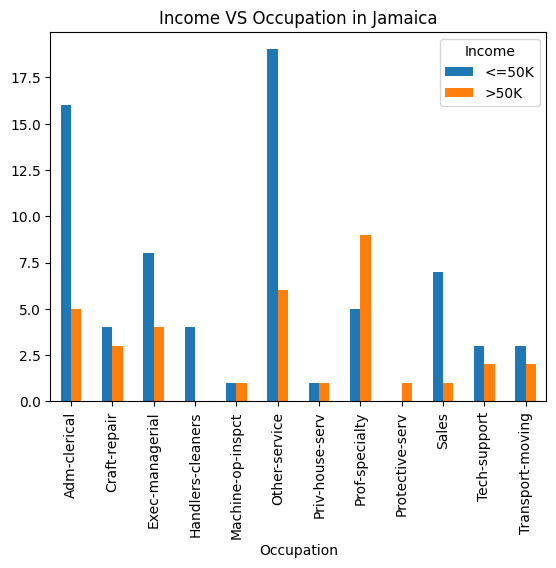

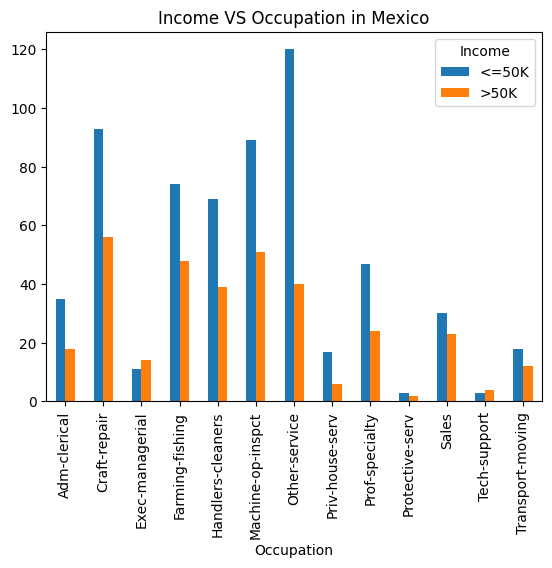

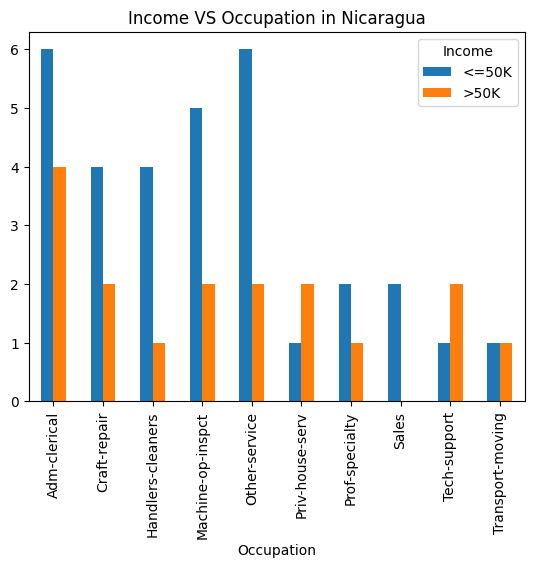

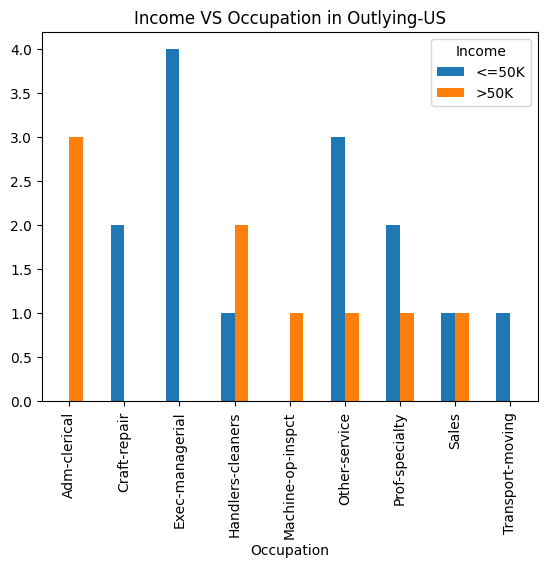

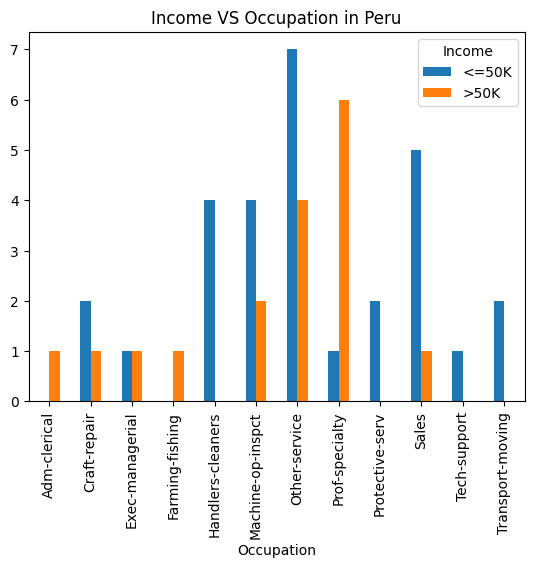

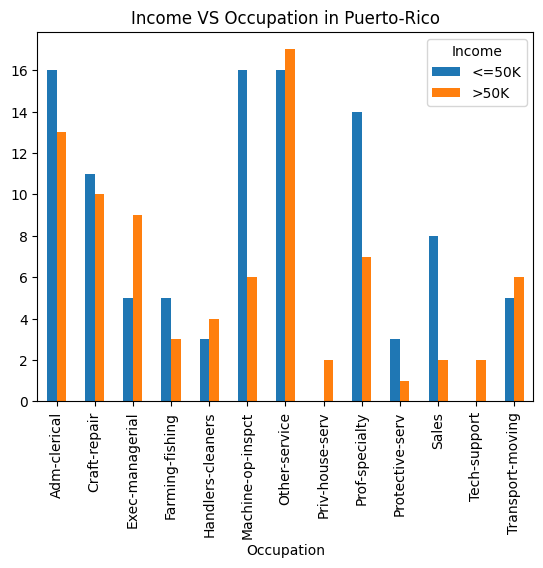

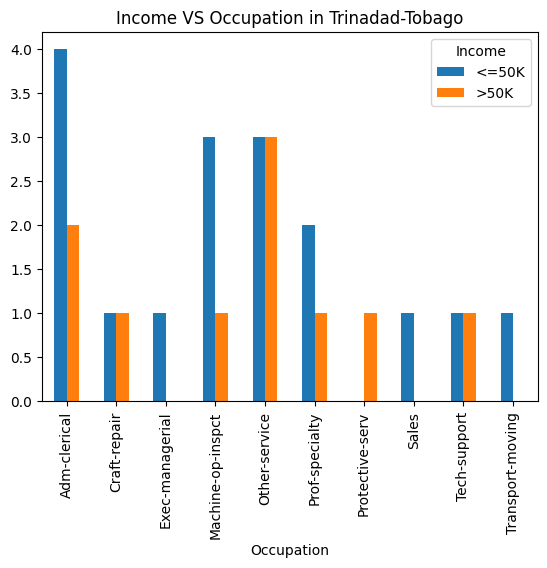

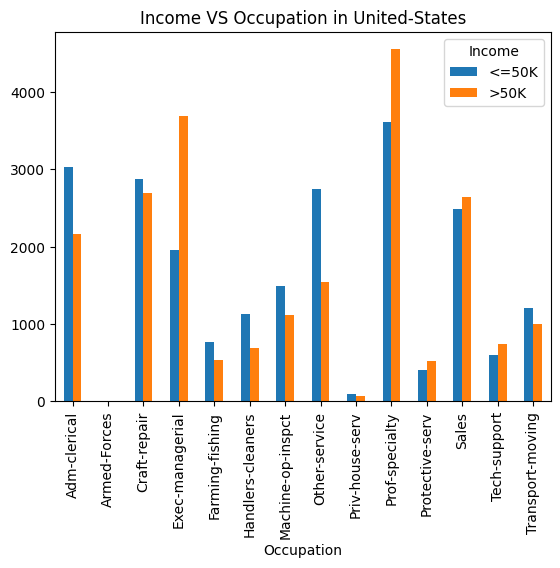

In [100]:
Occupation_VS_Income('America', df_no_outliers)

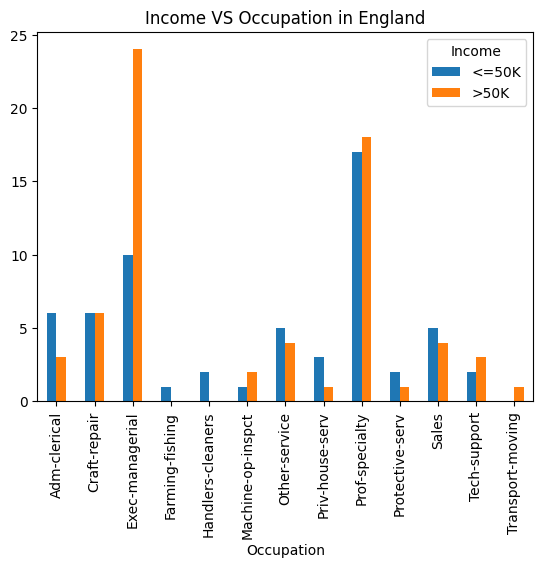

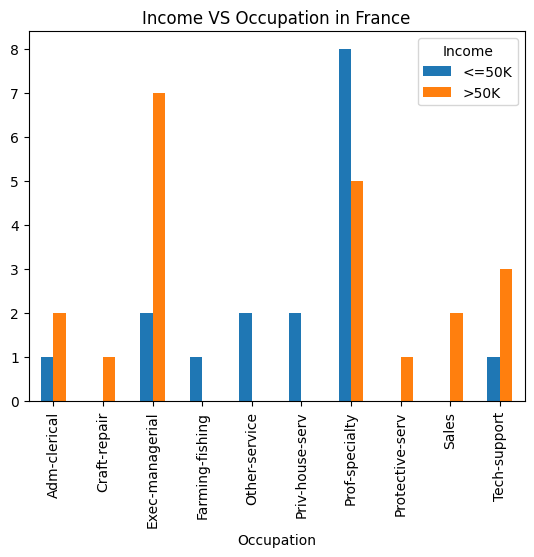

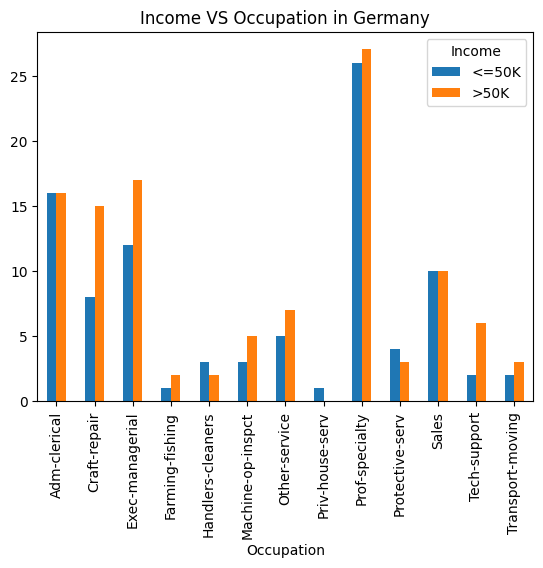

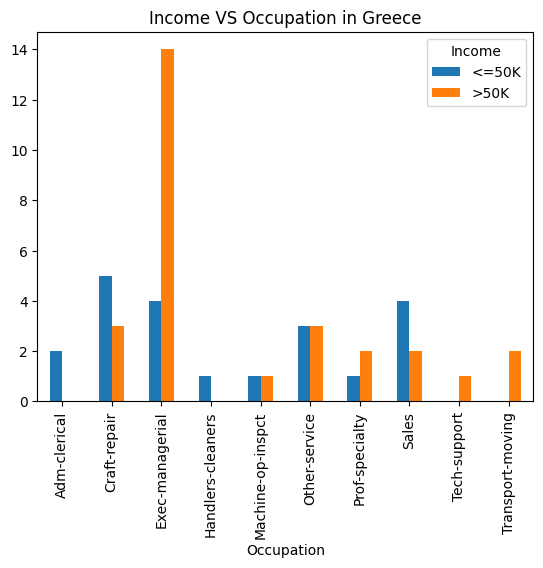

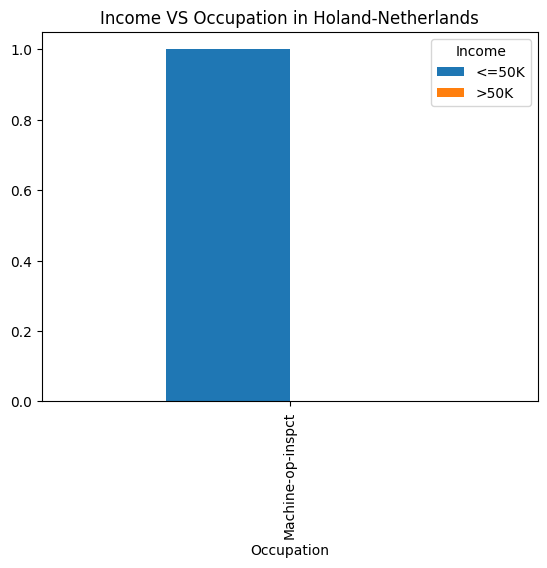

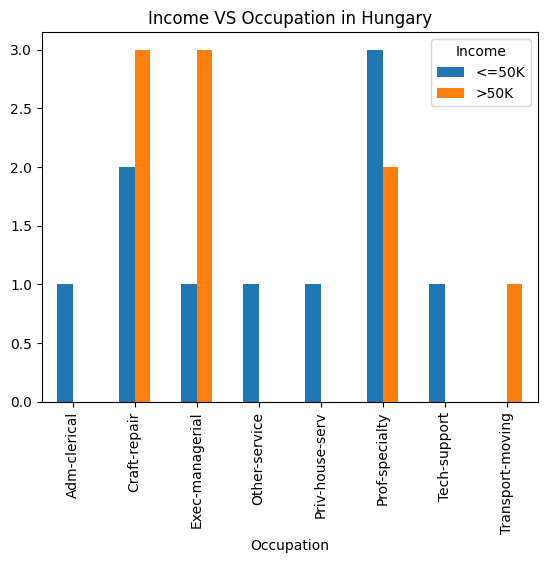

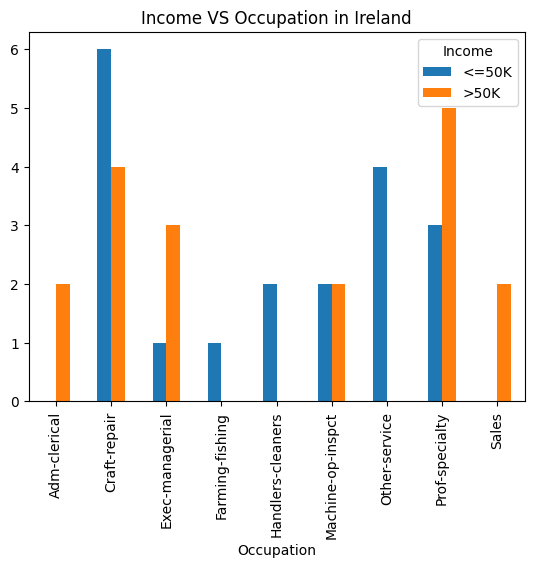

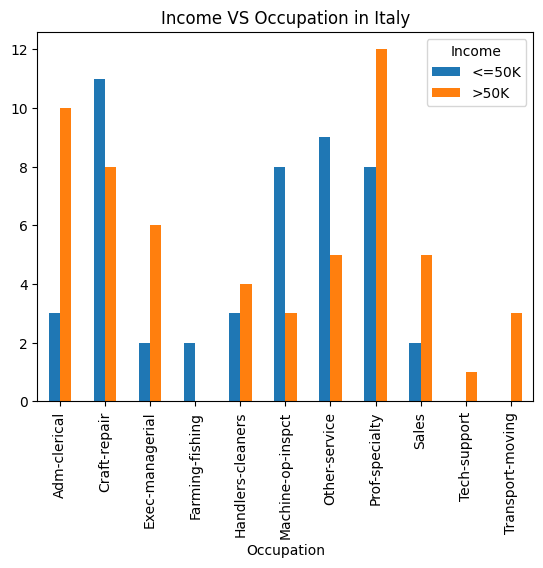

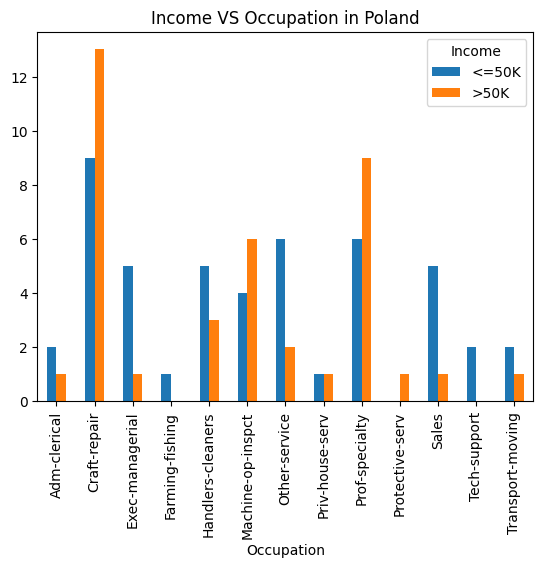

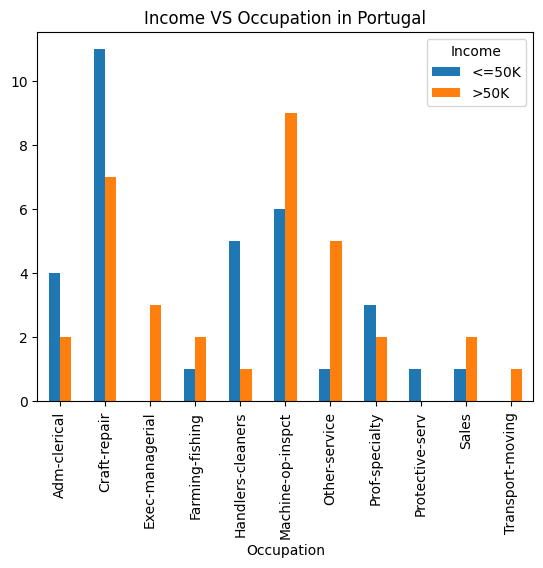

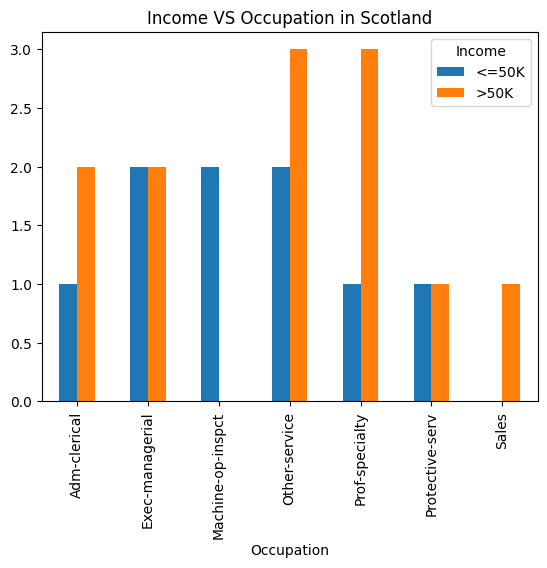

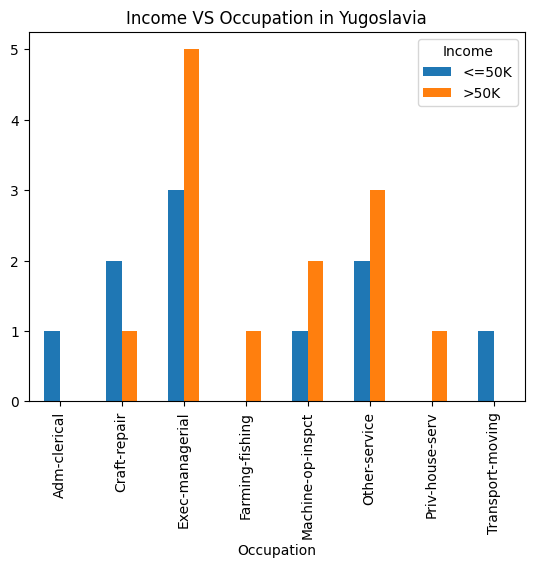

In [101]:
Occupation_VS_Income('Europe', df_no_outliers)

In [103]:
def Workclass_VS_Income(continent, df):
    choice = df[df['Continent']==continent] 
    
    # Aggregate data by country and workclass
    country_workclass_income = choice.groupby(['Country', 'Workclass', 'Income']).size().unstack(fill_value=0)
    
    # Plot for each country
    for country in country_workclass_income.index.levels[0]:
        country_data = country_workclass_income.loc[country]
        country_data.plot(kind='bar', title='Income VS Workclass in {}'.format(country))
        plt.show()  # Display the plot


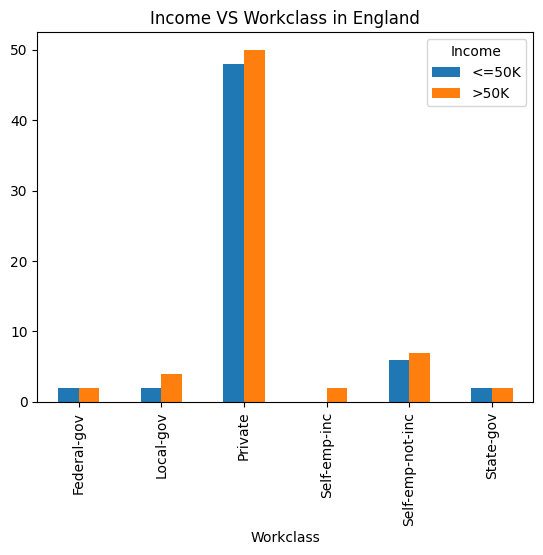

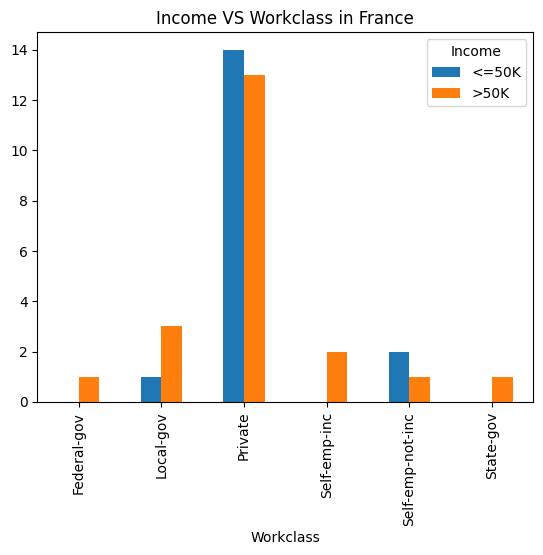

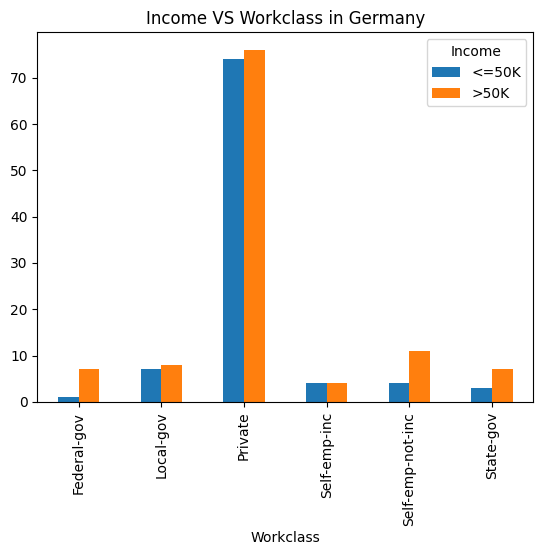

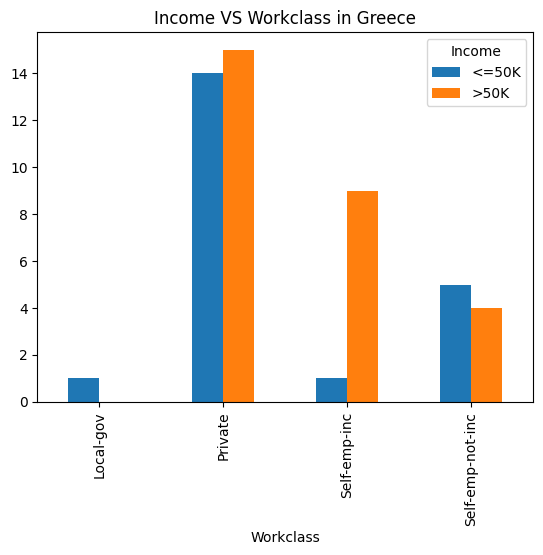

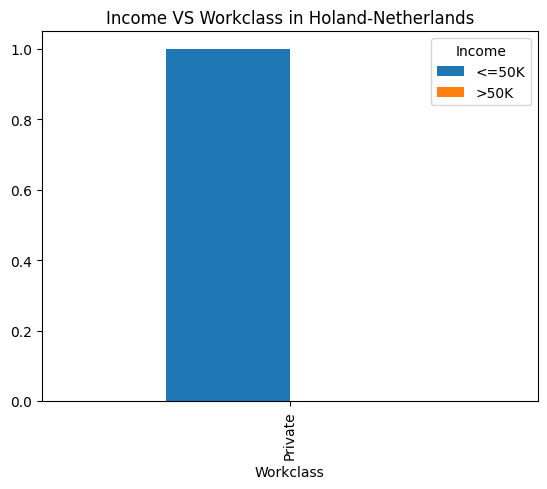

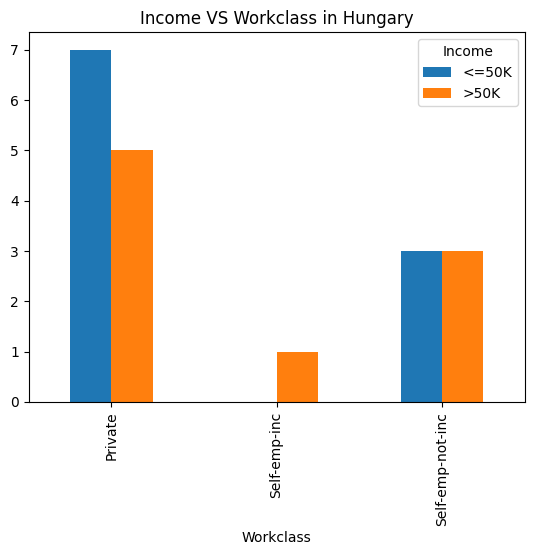

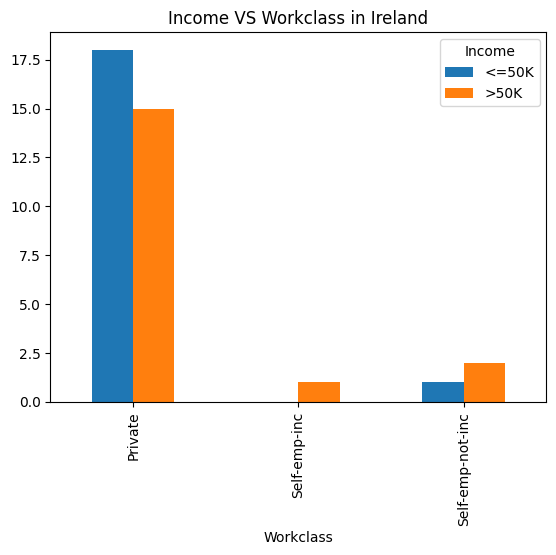

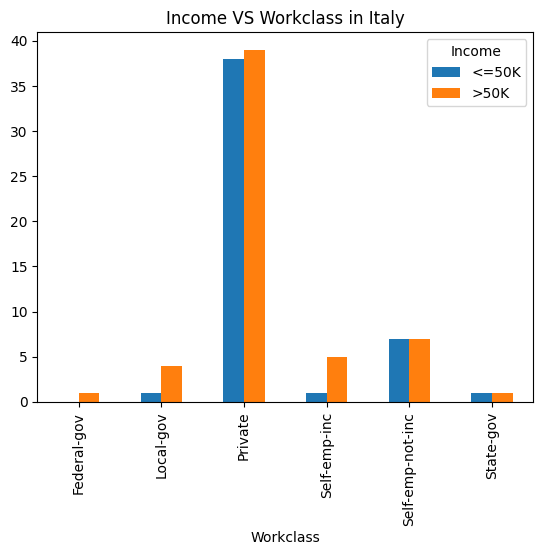

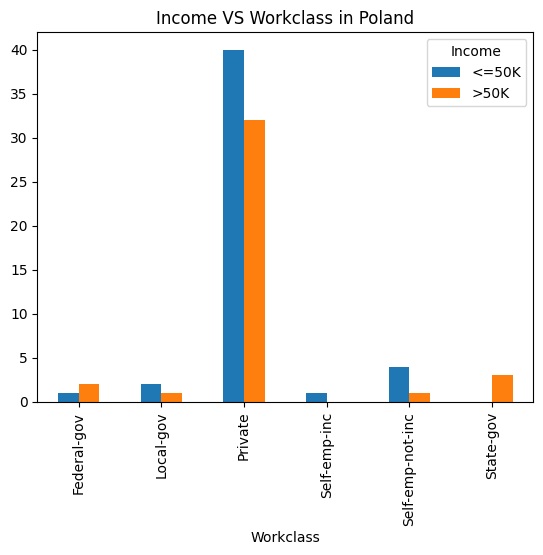

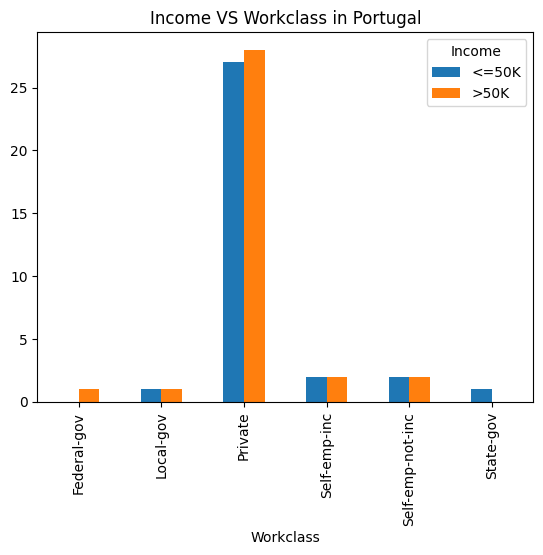

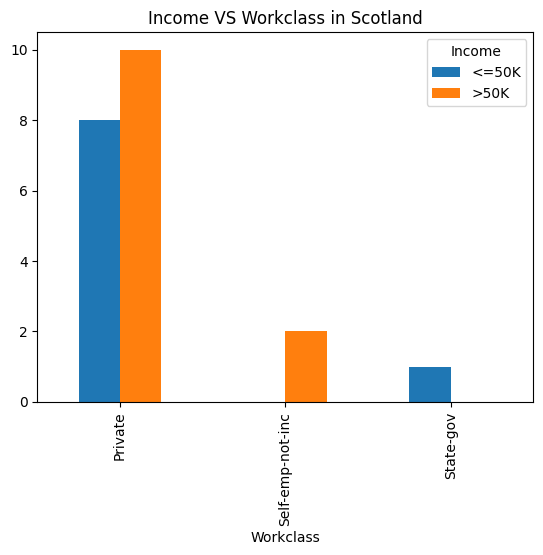

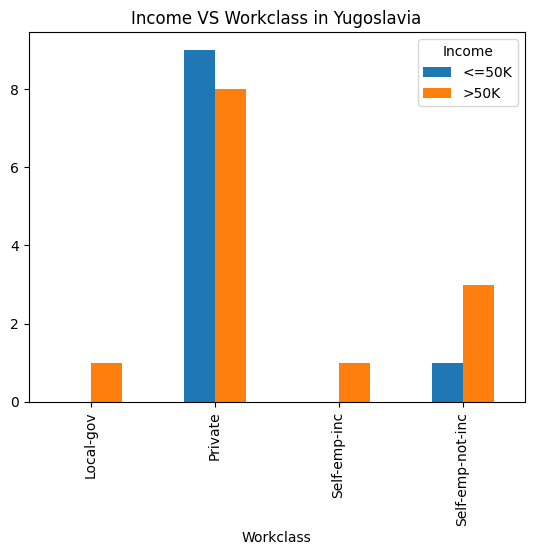

In [104]:
Workclass_VS_Income('Europe', df_no_outliers)

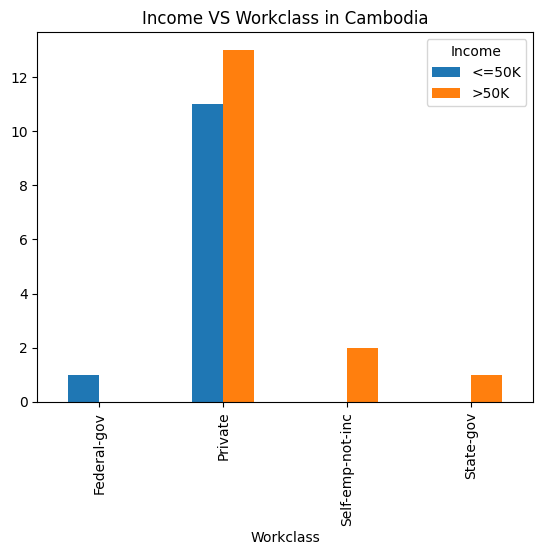

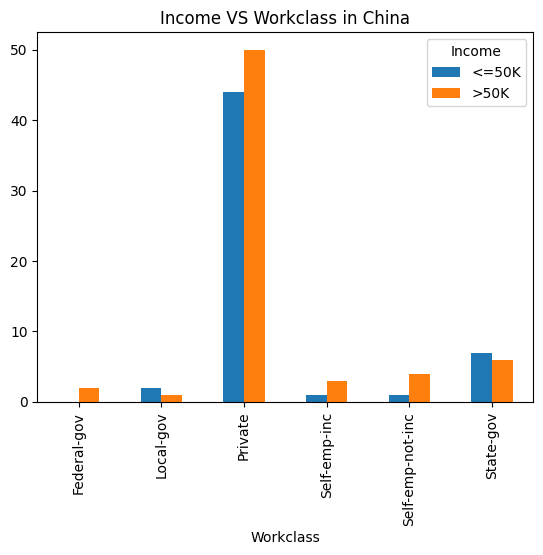

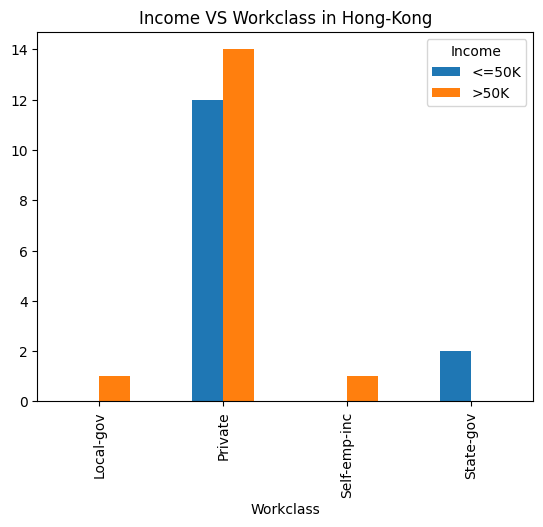

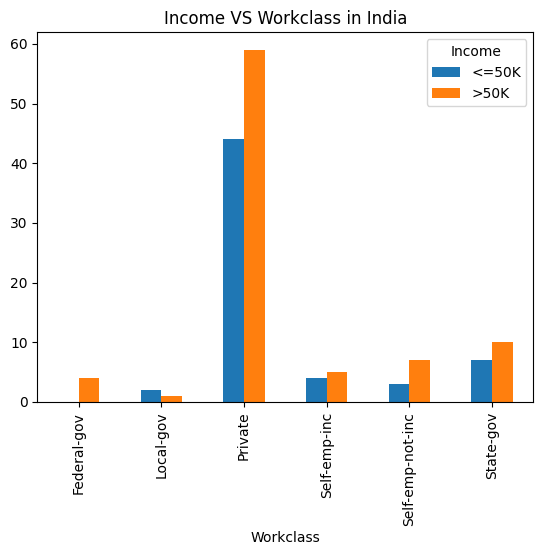

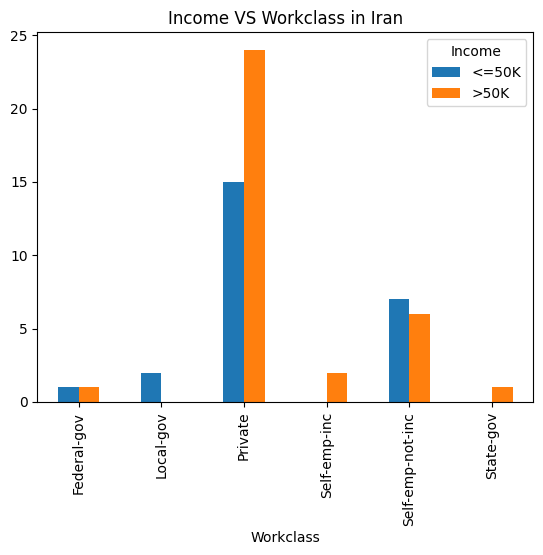

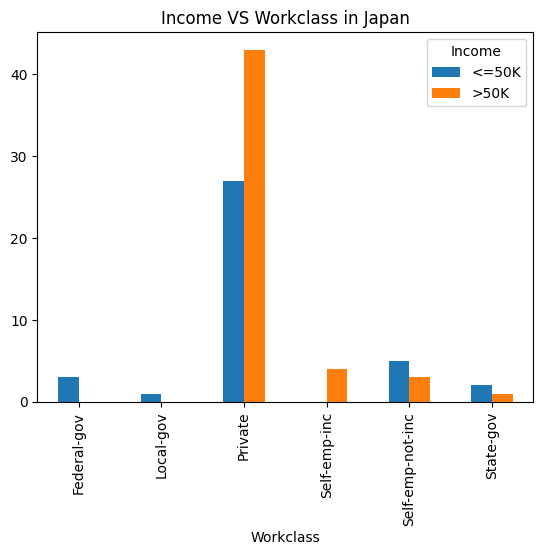

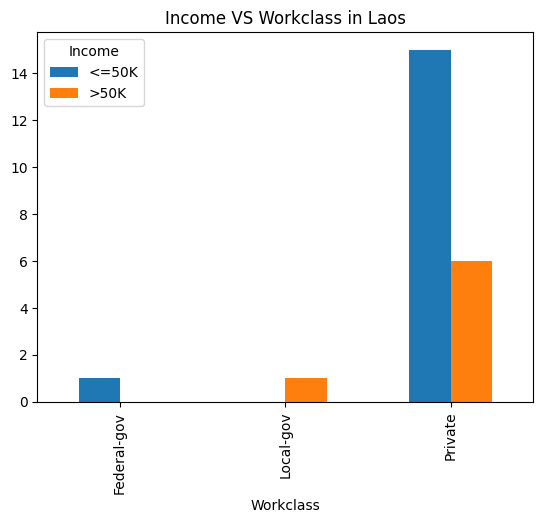

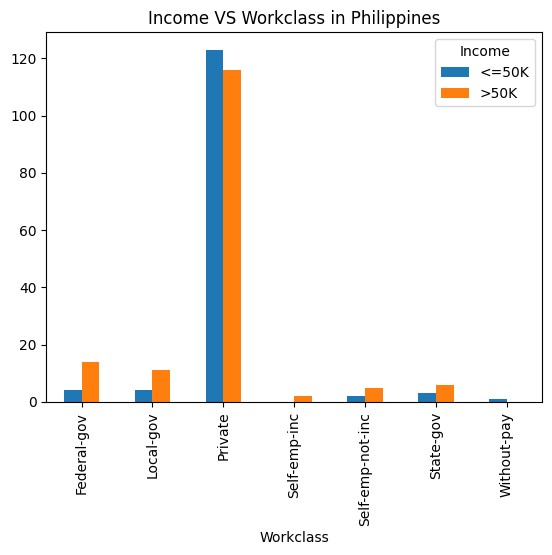

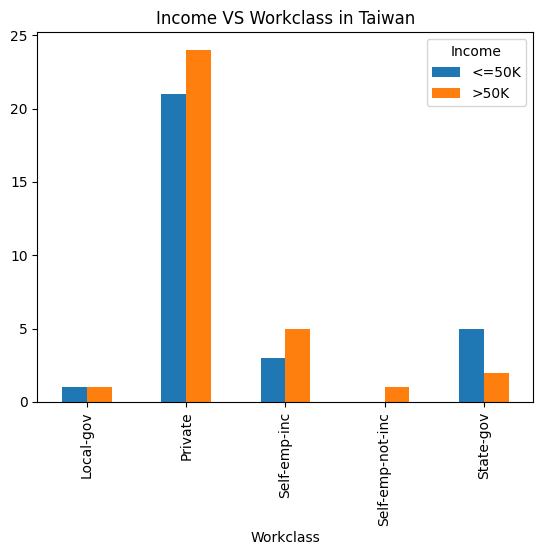

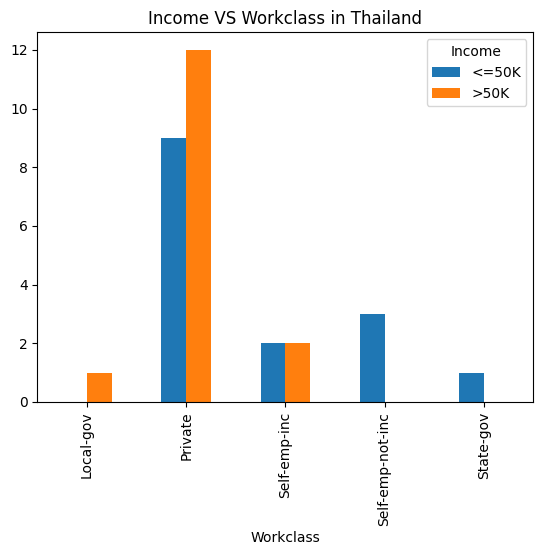

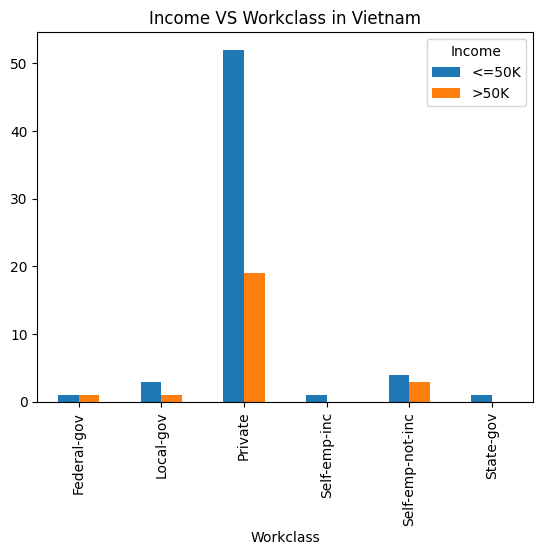

In [105]:
Workclass_VS_Income('Asia', df_no_outliers)

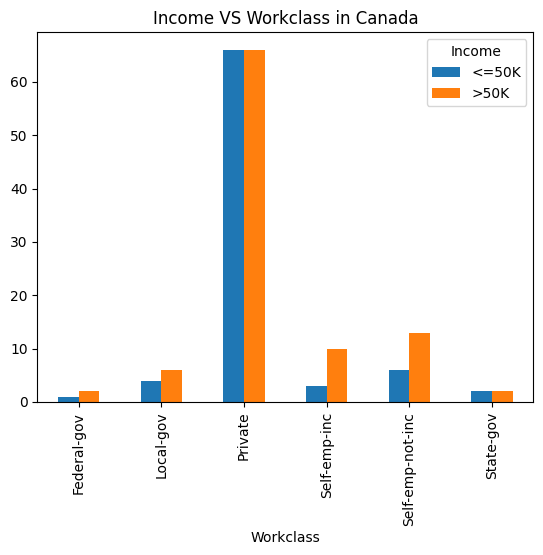

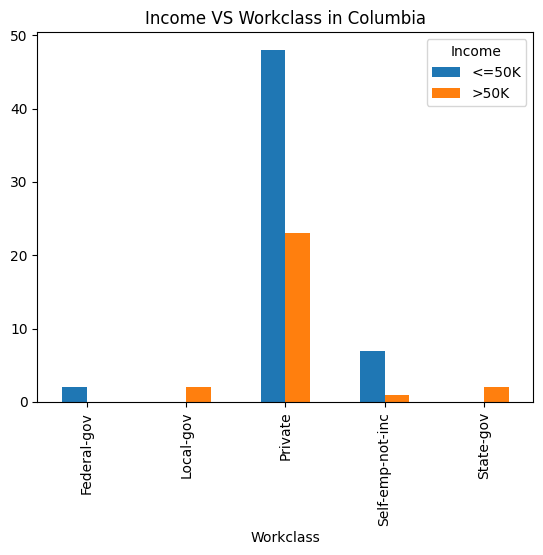

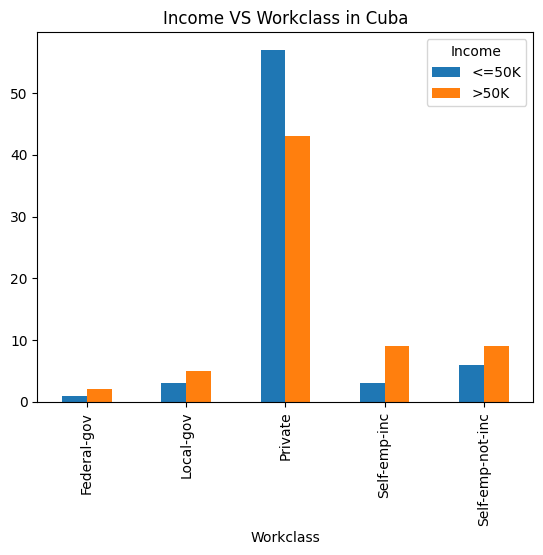

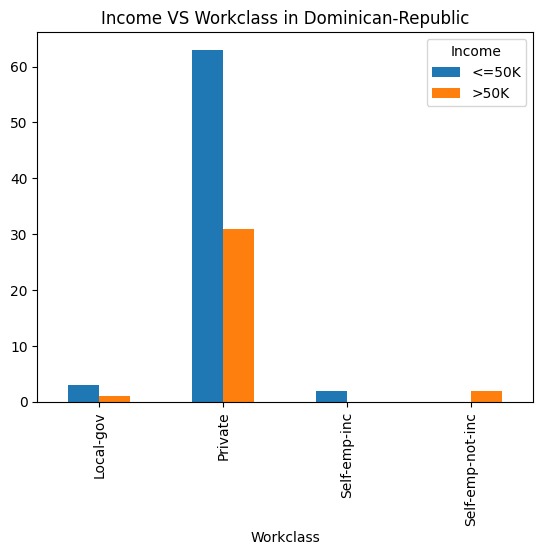

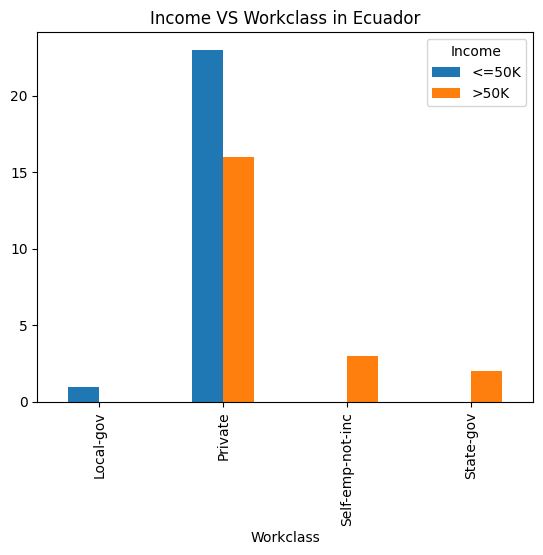

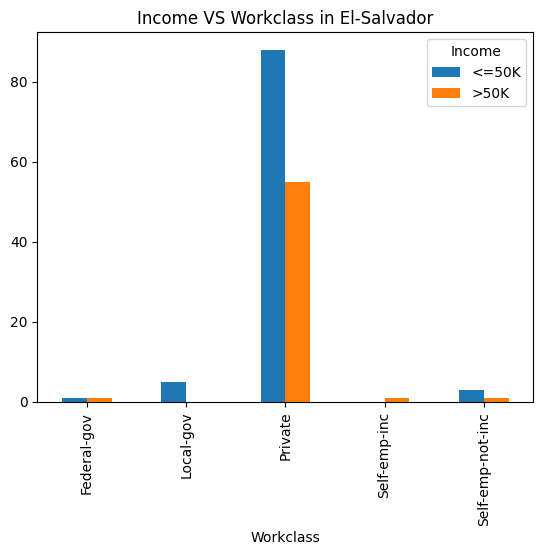

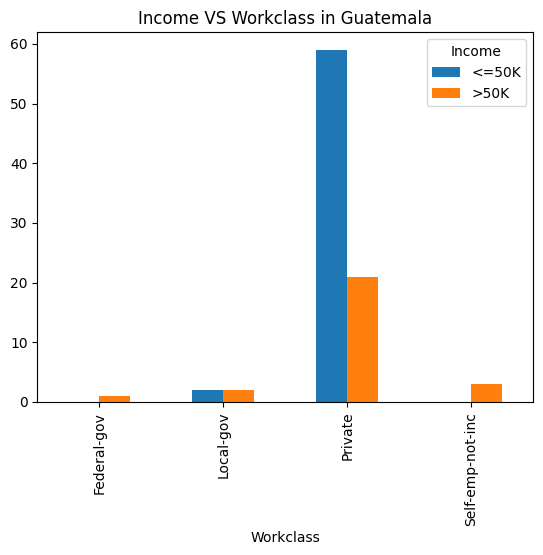

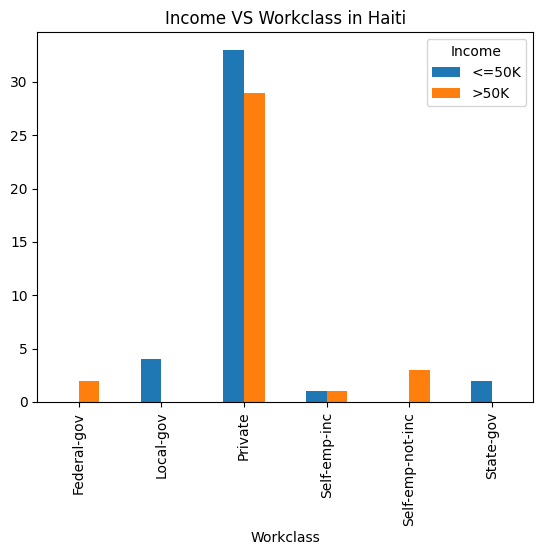

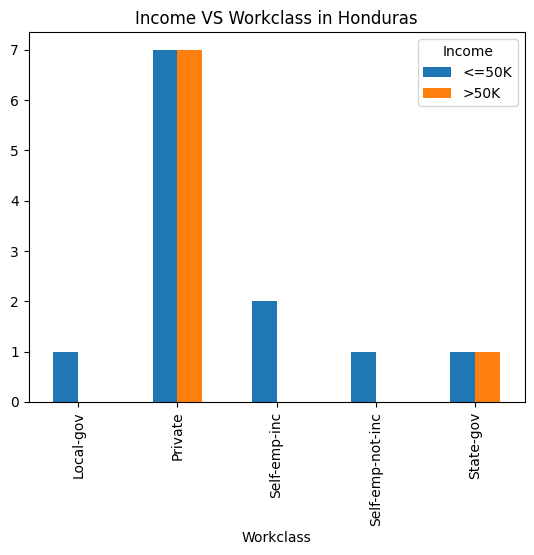

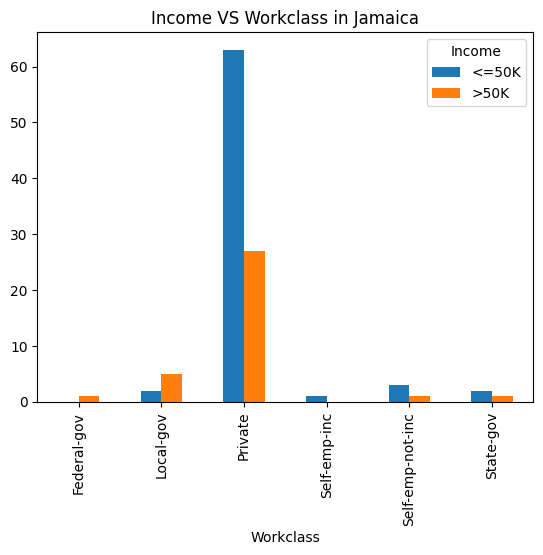

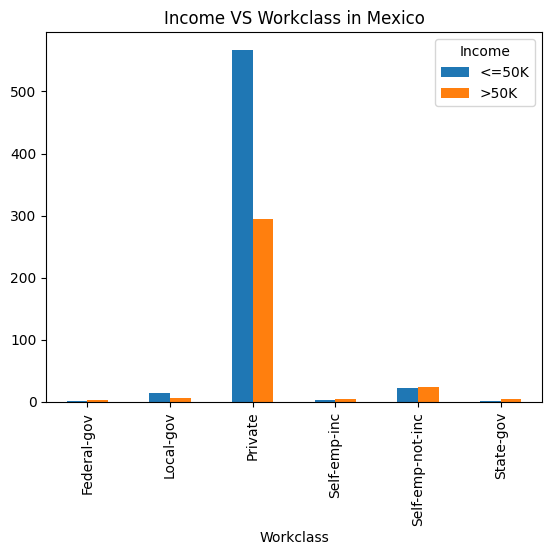

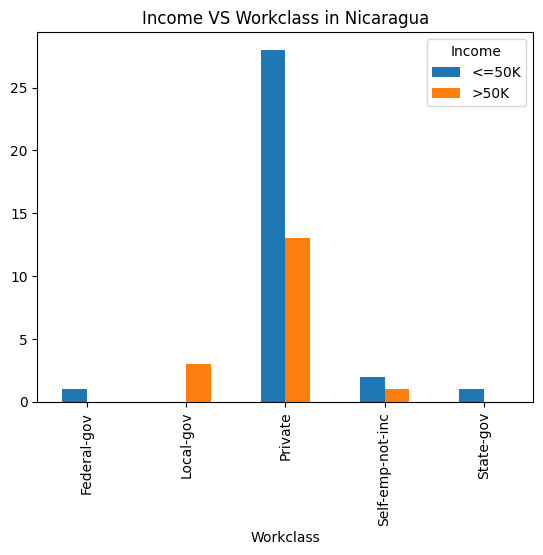

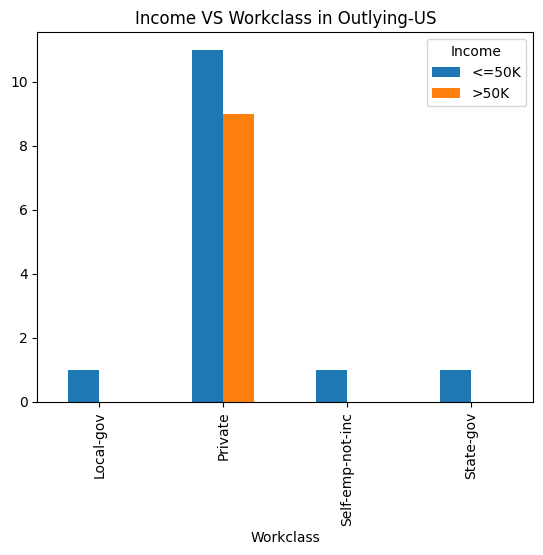

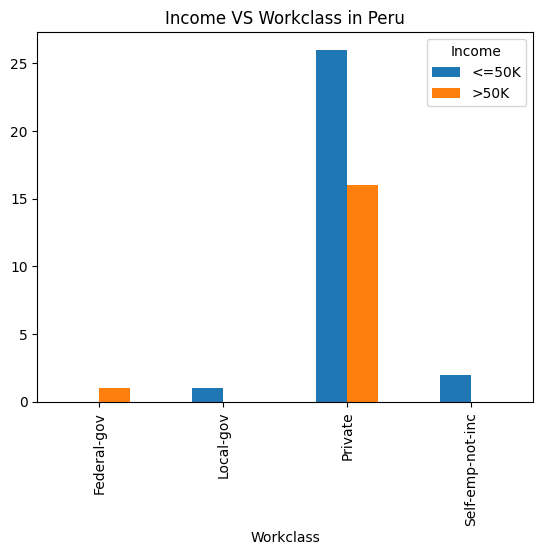

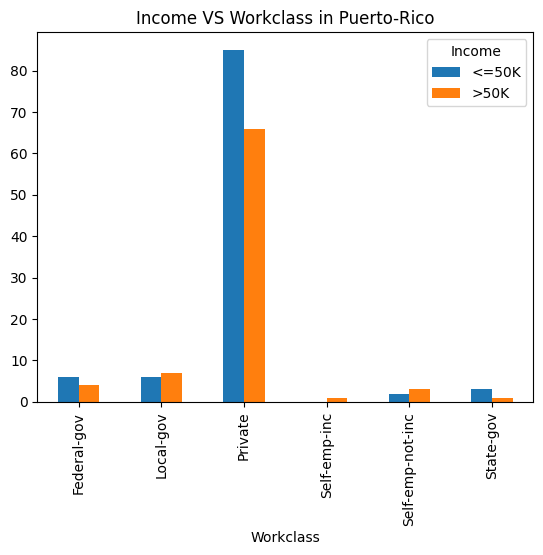

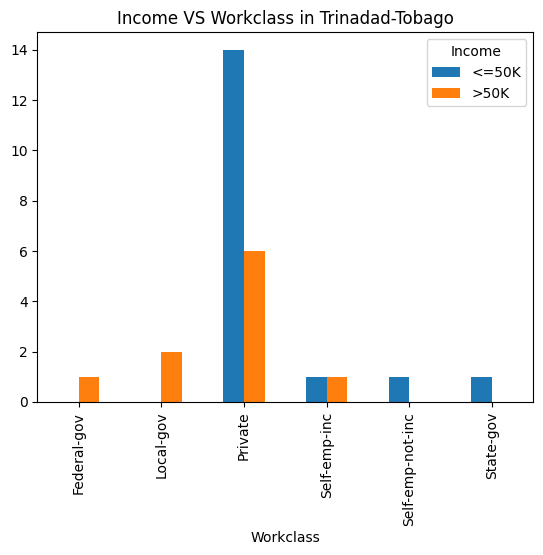

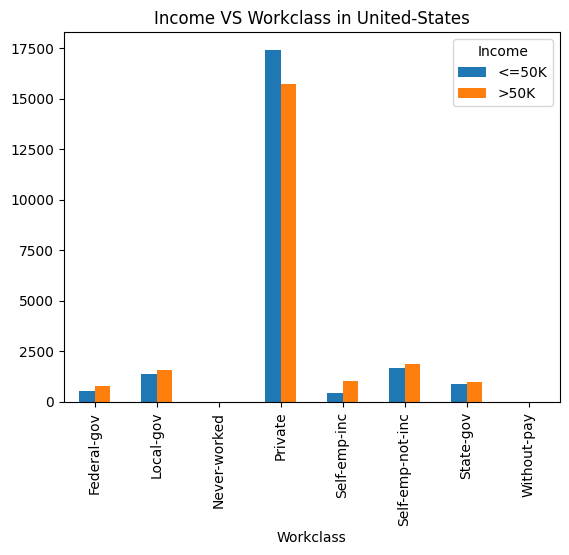

In [106]:
Workclass_VS_Income('America', df_no_outliers)

In [109]:
def MaritalStatus_VS_Income(continent, df):
    choice = df[df['Continent']==continent] 
    
    # Aggregate data by country and marital status
    country_maritalstatus_income = choice.groupby(['Country', 'Martial Status', 'Income']).size().unstack(fill_value=0)
    
    # Plot for each country
    for country in country_maritalstatus_income.index.levels[0]:
        country_data = country_maritalstatus_income.loc[country]
        country_data.plot(kind='bar', title='Income VS Marital Status in {}'.format(country))
        plt.show()  # Display the plot

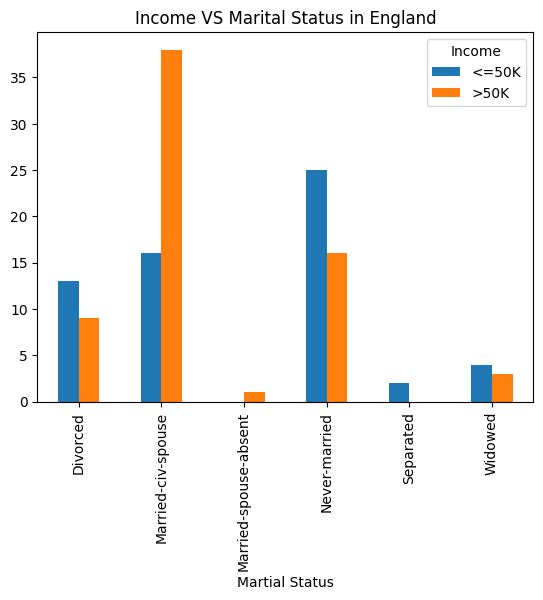

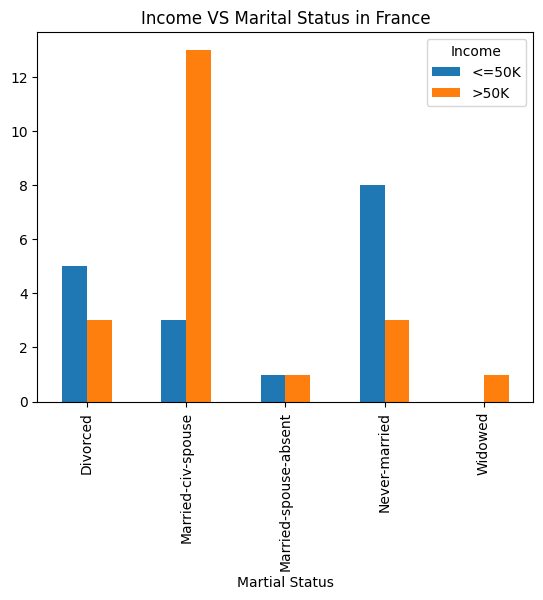

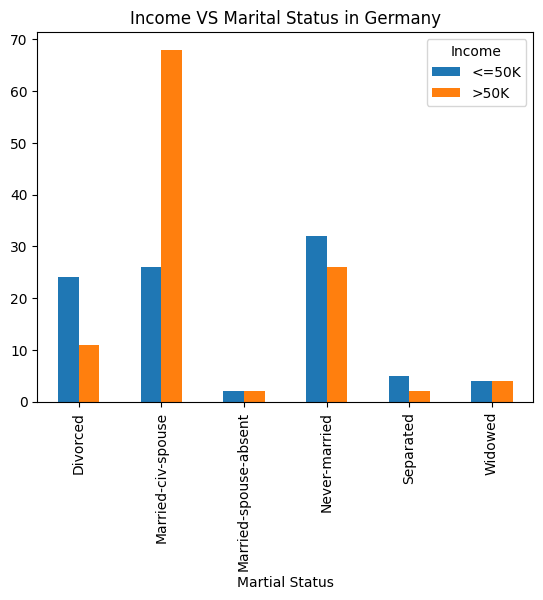

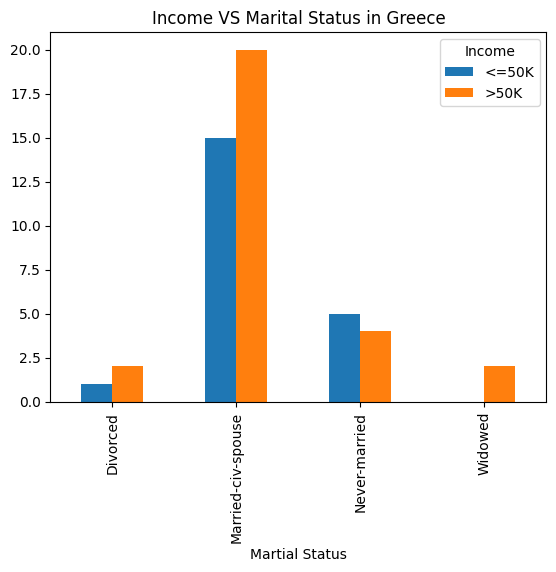

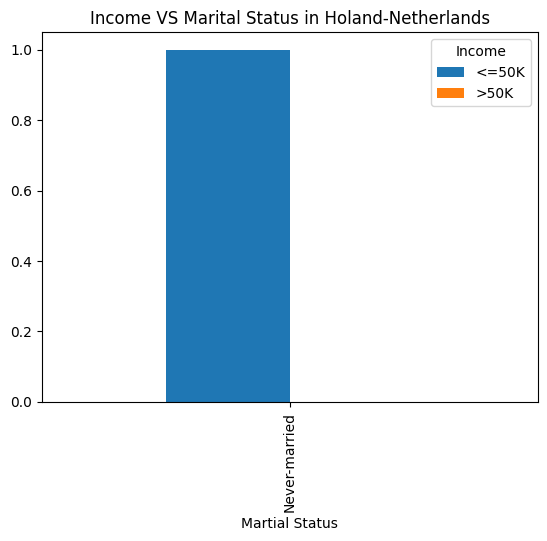

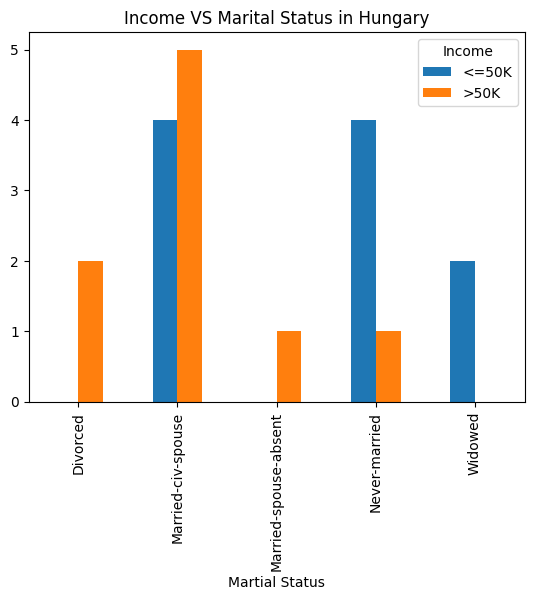

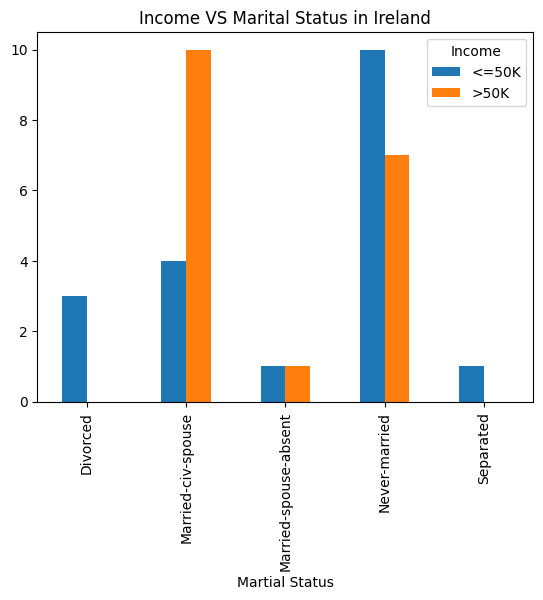

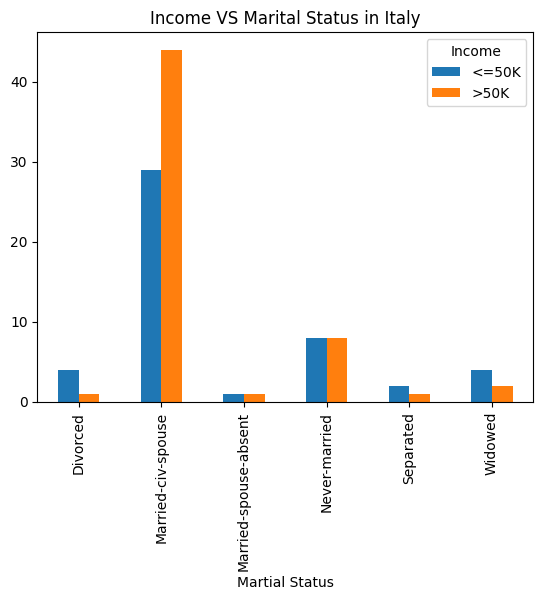

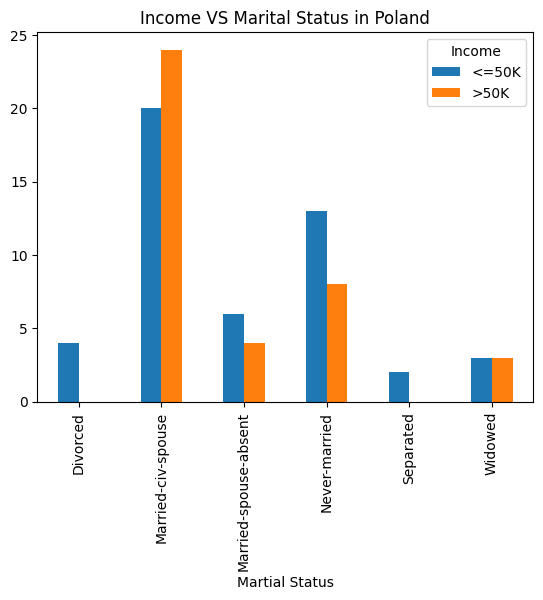

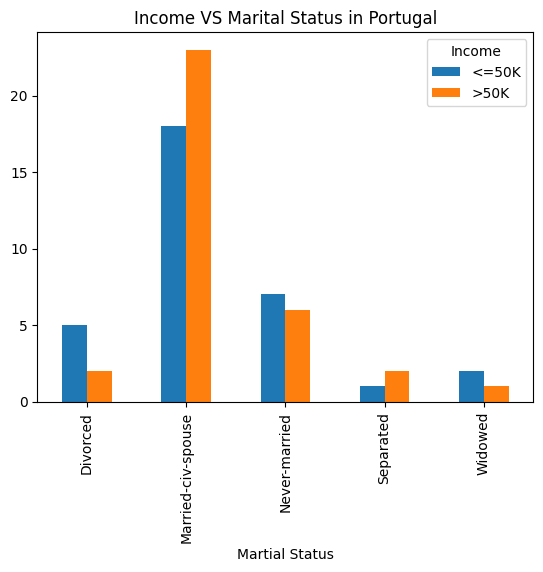

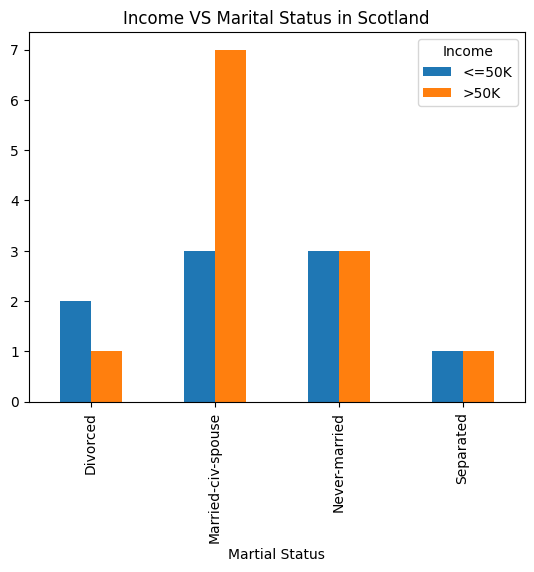

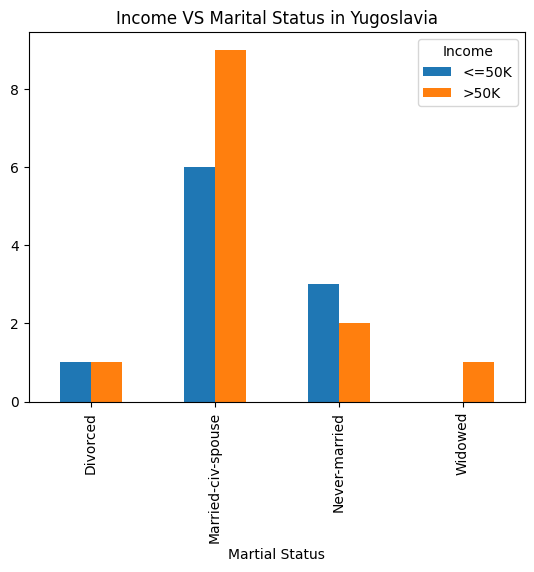

In [110]:
MaritalStatus_VS_Income('Europe', df_no_outliers)

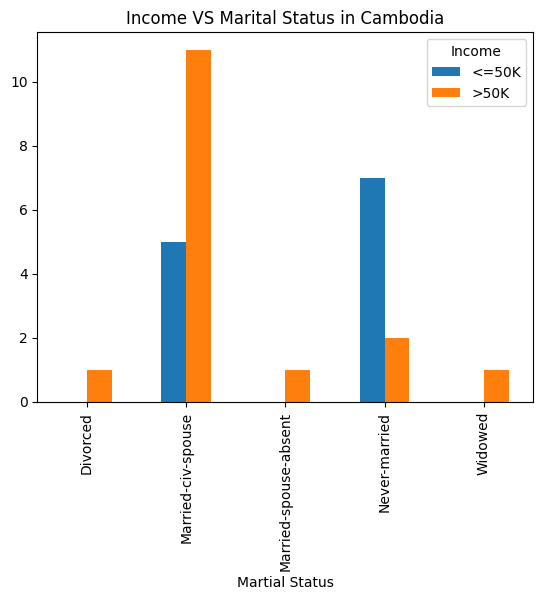

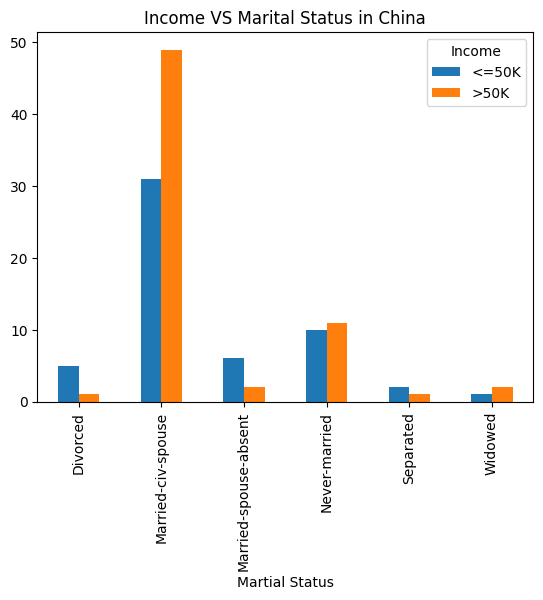

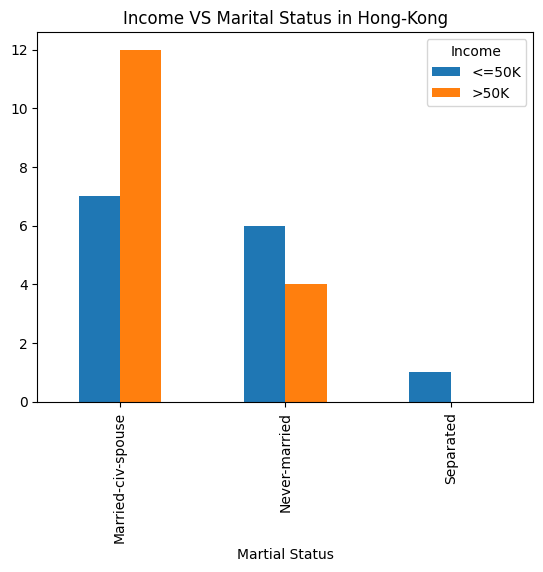

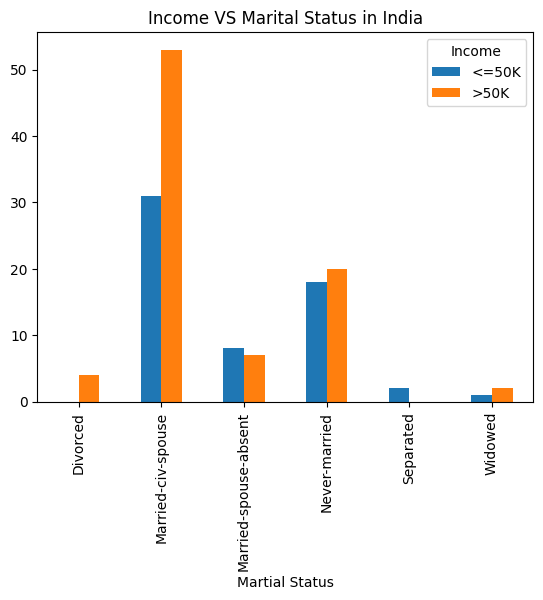

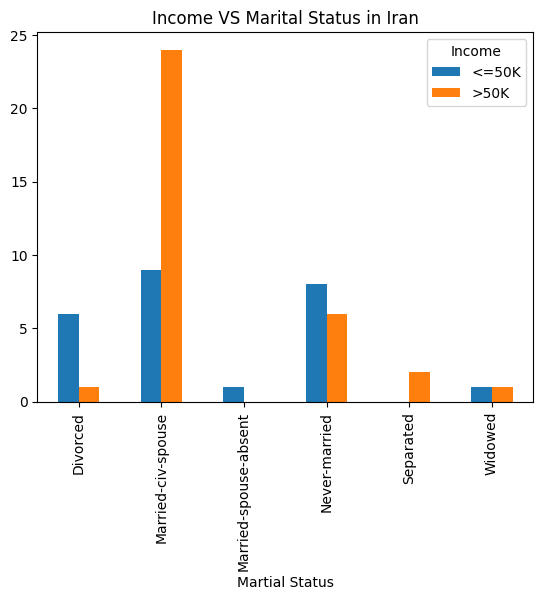

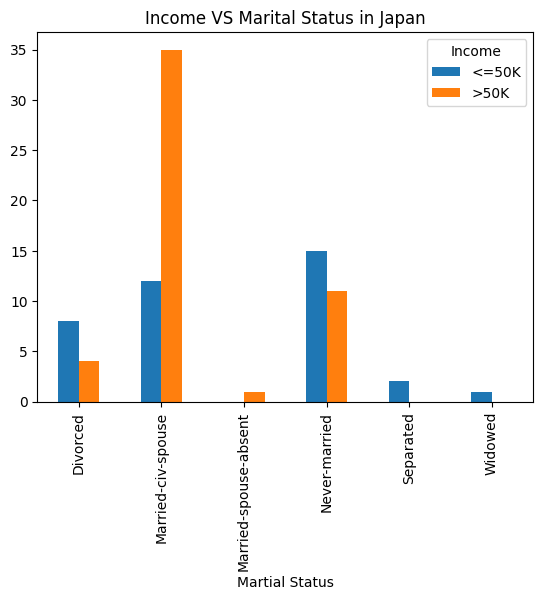

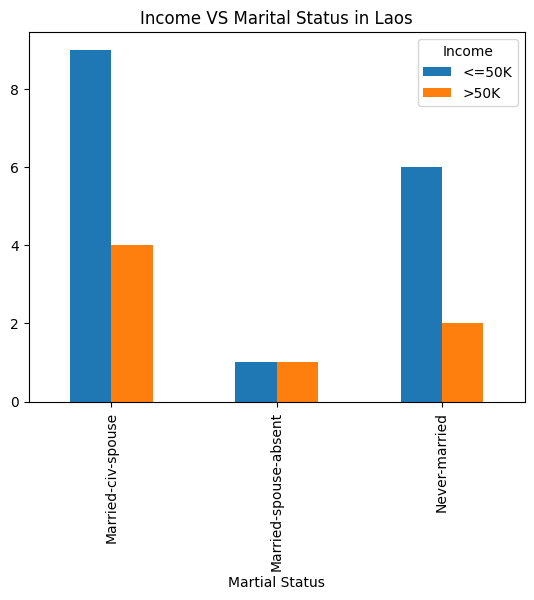

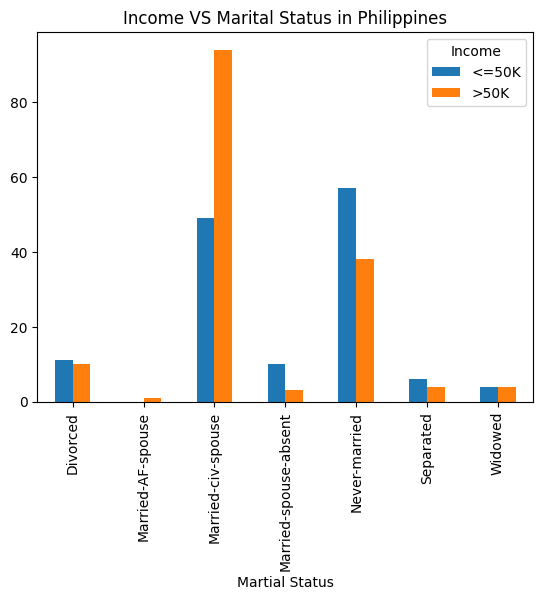

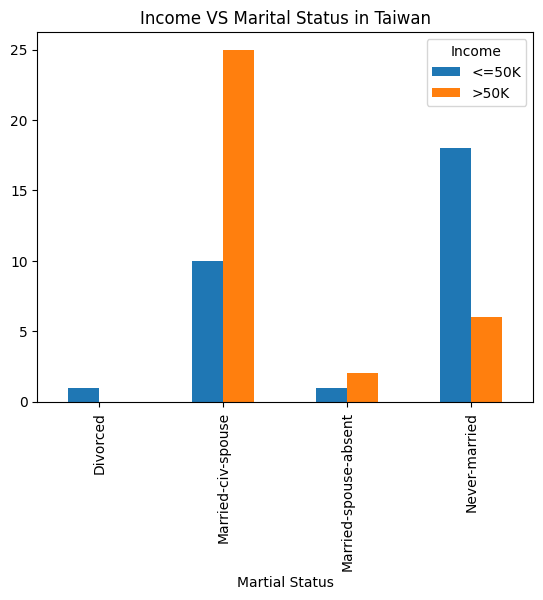

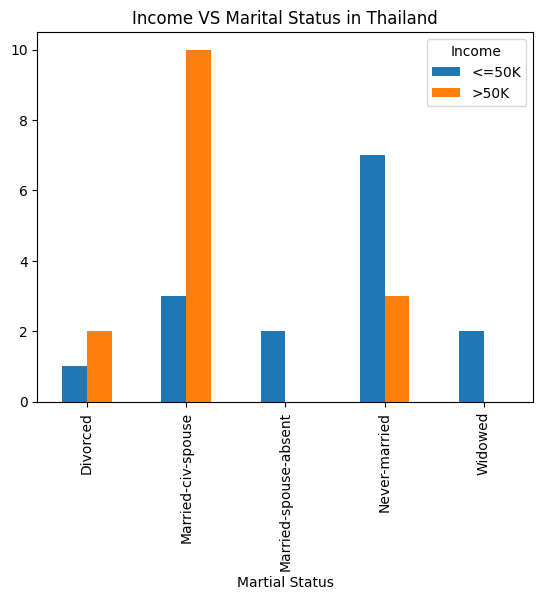

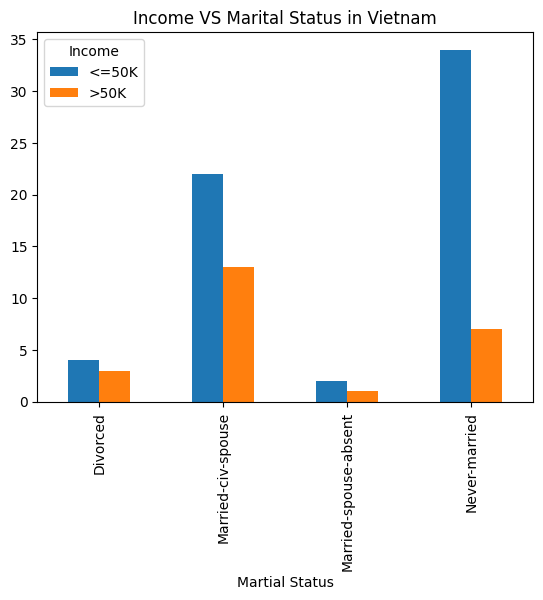

In [111]:
MaritalStatus_VS_Income('Asia', df_no_outliers)

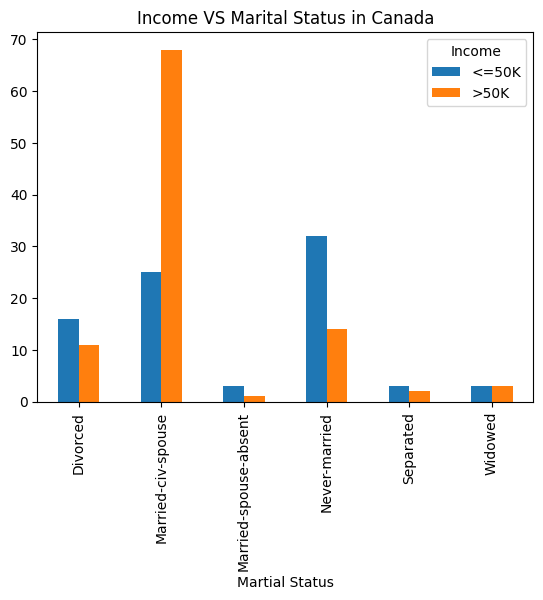

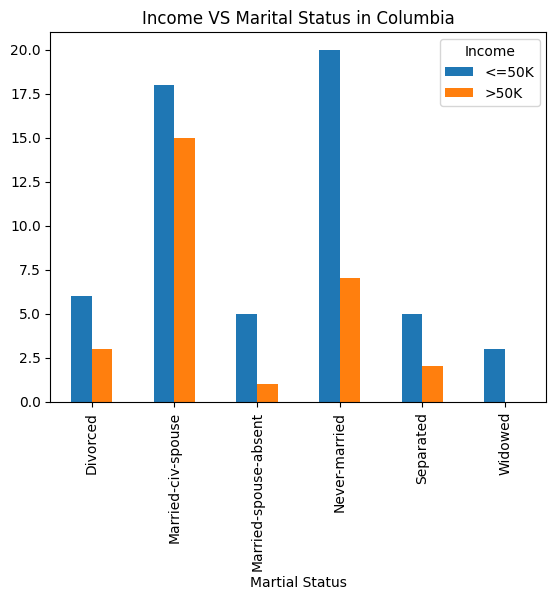

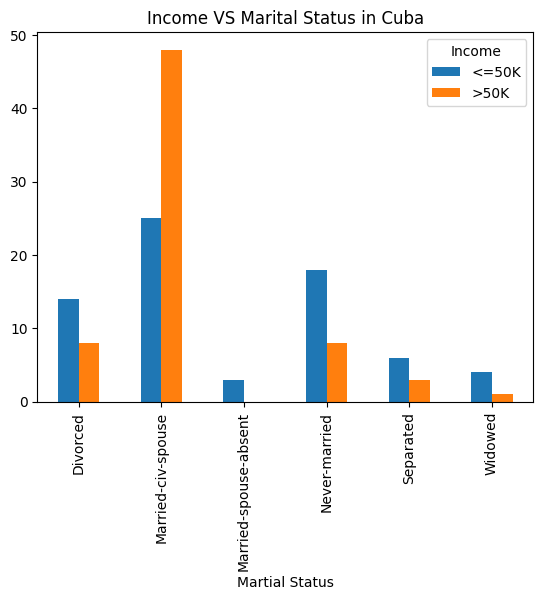

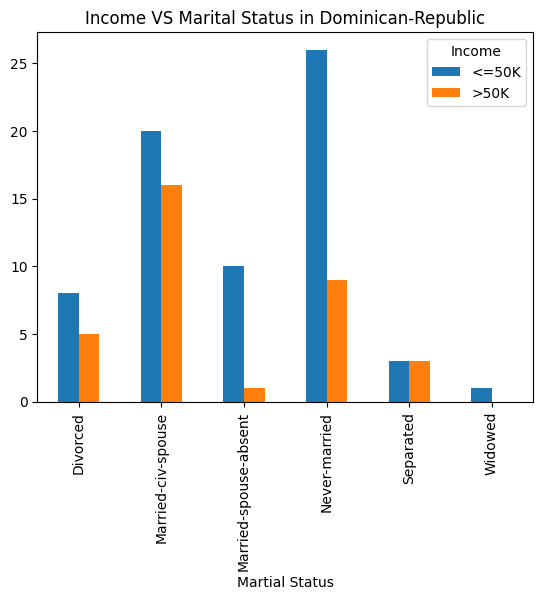

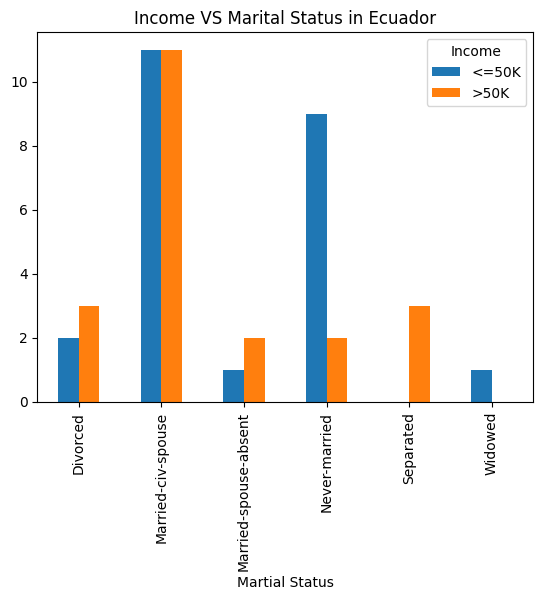

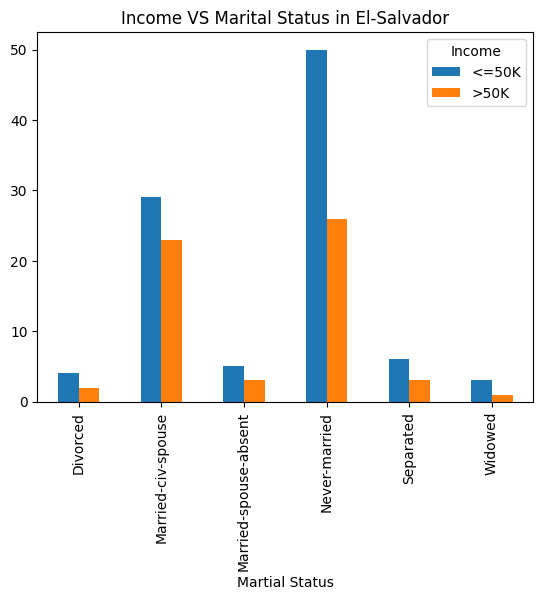

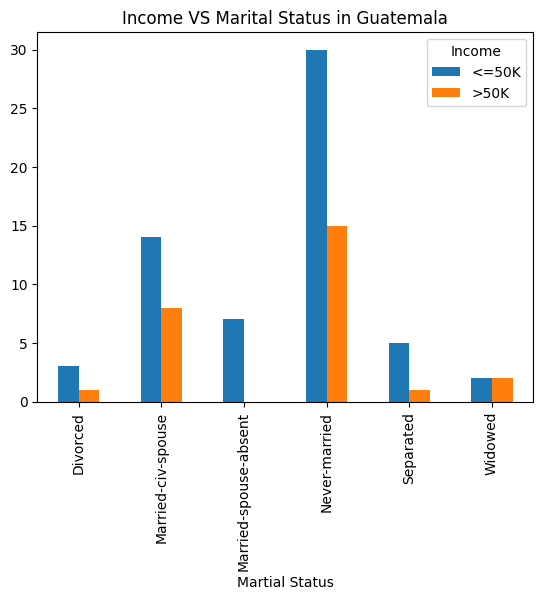

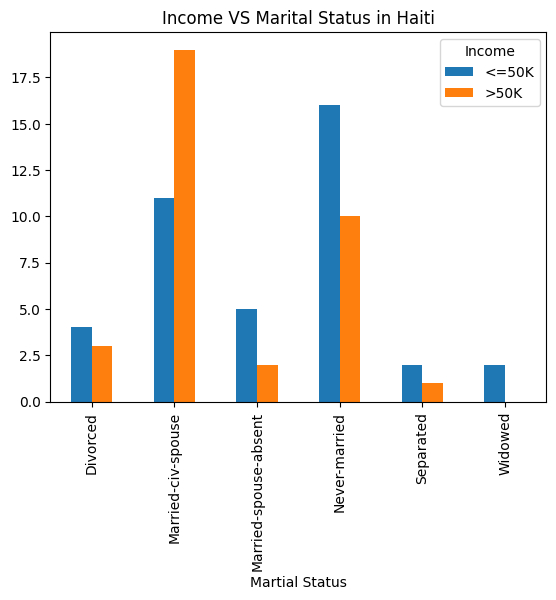

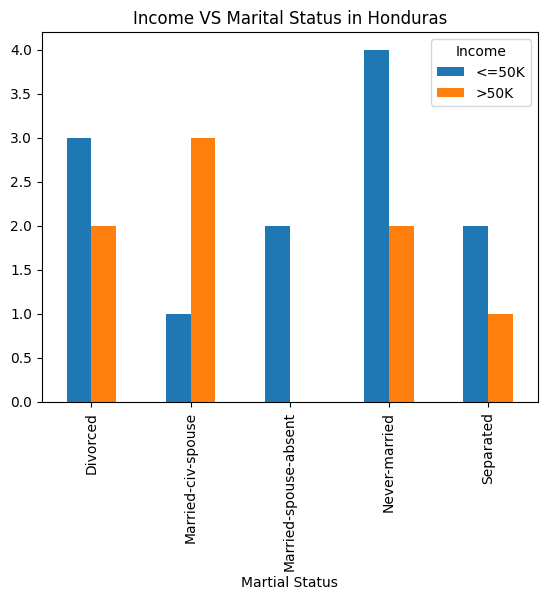

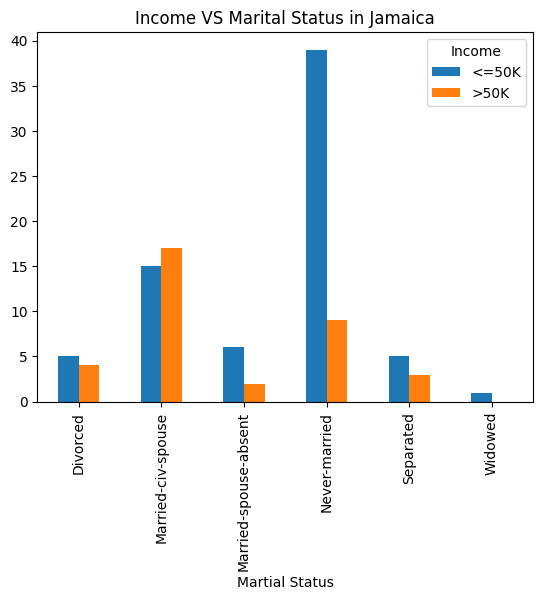

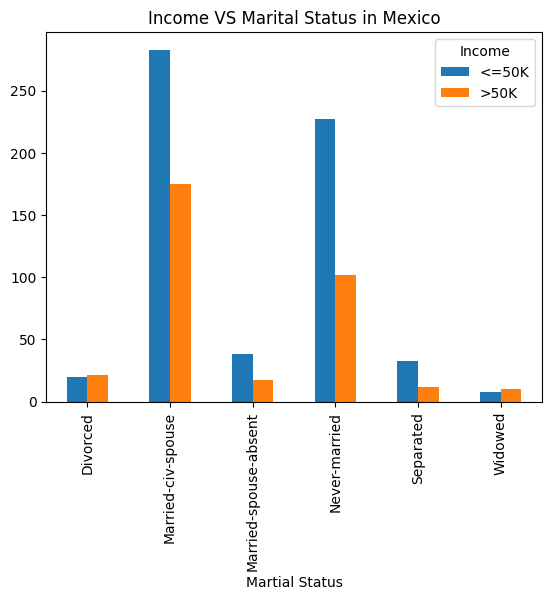

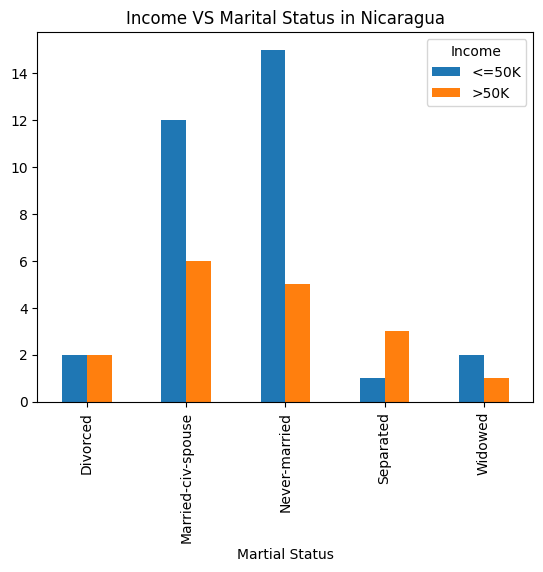

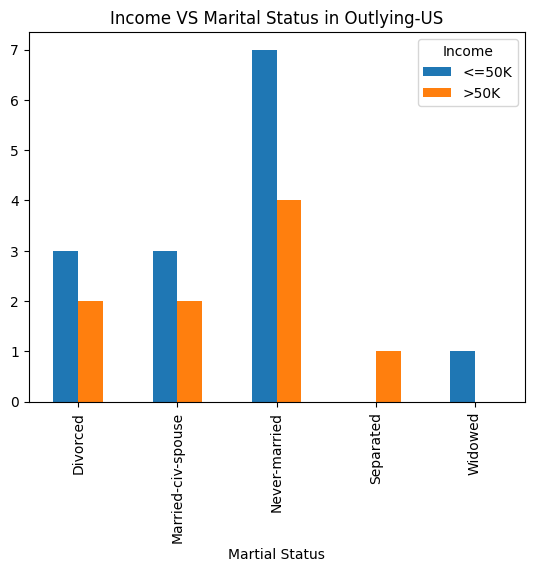

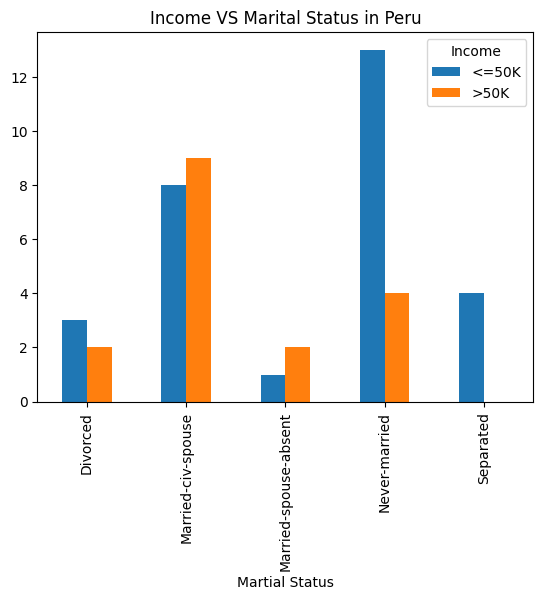

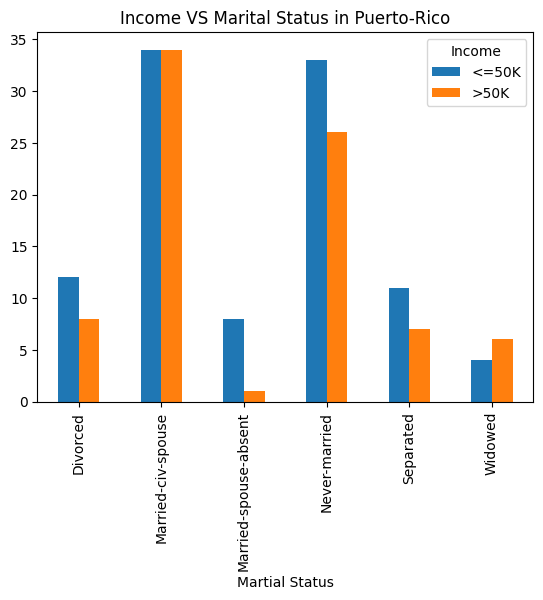

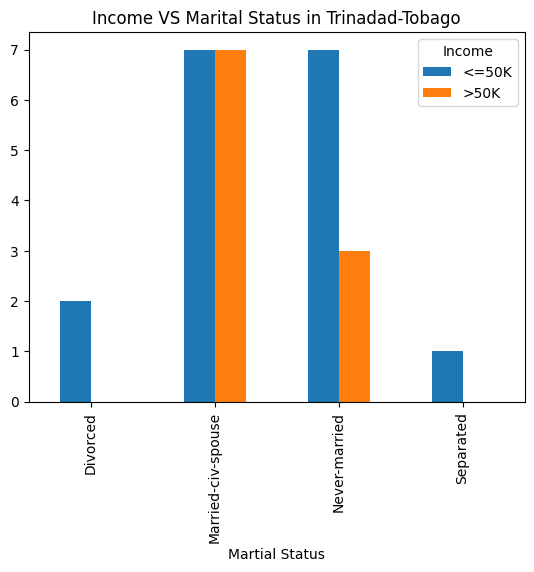

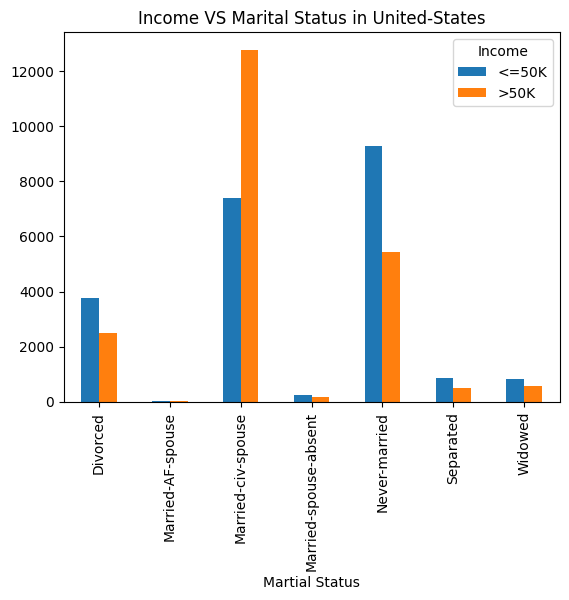

In [112]:
MaritalStatus_VS_Income('America', df_no_outliers)

Mean Capital Gain VS Martial Status for each continent

In [116]:
agg_df = df_no_outliers.groupby(['Continent','Country', 'Martial Status'])['Capital-Gain'].mean().reset_index()

agg_df['Mean_Capital_Gain'] = agg_df['Capital-Gain']
agg_df.drop('Capital-Gain', axis=1, inplace=True)

agg_df.head()

Continent Country         Martial Status  Mean_Capital_Gain
0   America  Canada               Divorced           0.000000
1   America  Canada     Married-civ-spouse        1338.698925
2   America  Canada  Married-spouse-absent           0.000000
3   America  Canada          Never-married           0.000000
4   America  Canada              Separated           0.000000

In [121]:
def Mean_TotCapital_VS_Marital_Status(continent, df):
    choice = df[df['Continent']==continent] 
    countries = list(choice['Country'].unique())

    for country in countries:
        df_c = choice[choice['Country']==country]
        ax = sns.catplot(x='Martial Status', y='Mean_Capital_Gain', 
                         kind='bar', data=df_c)

        ax.figure.suptitle('Country: {}'.format(country))
        ax.figure.autofmt_xdate()


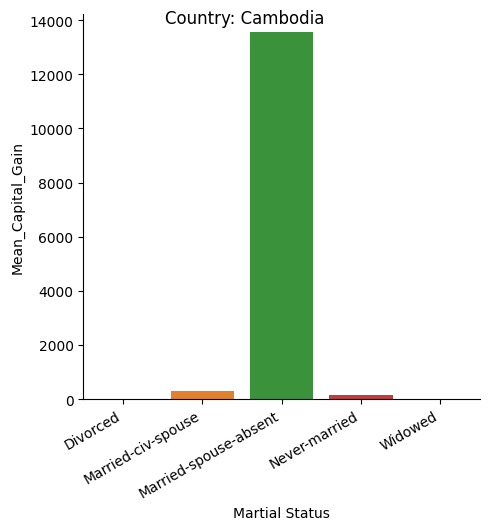

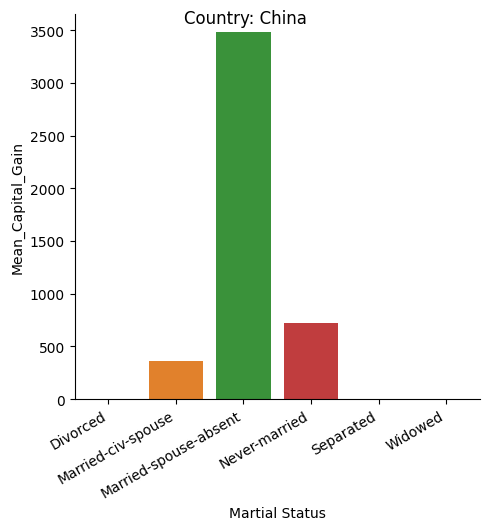

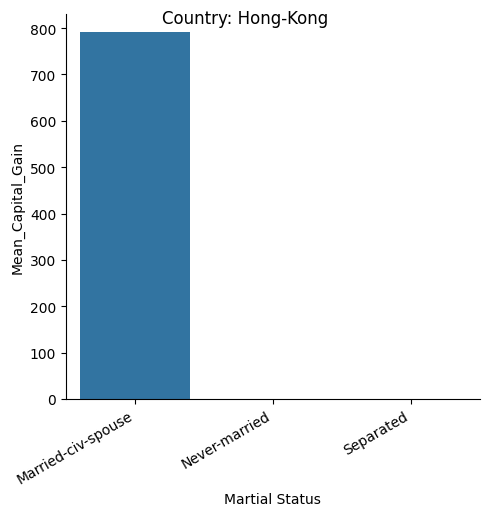

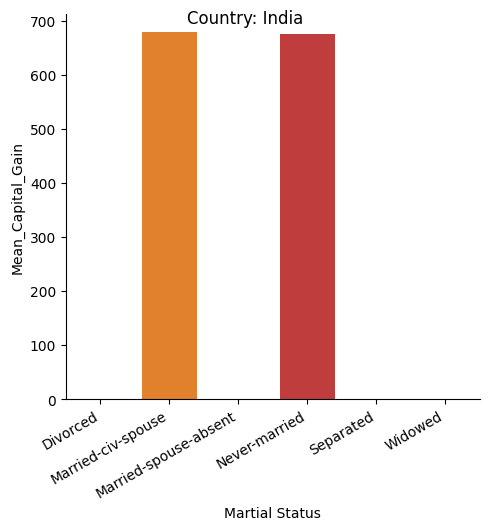

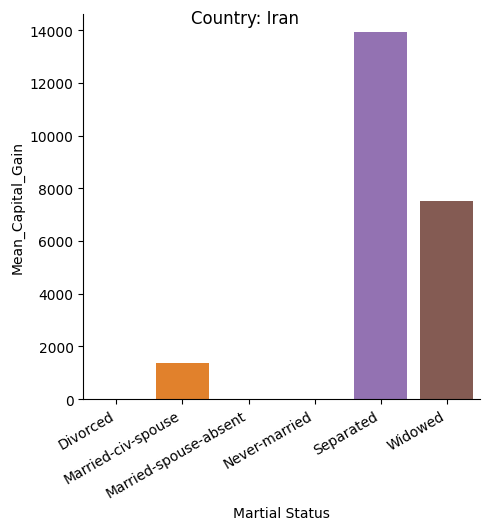

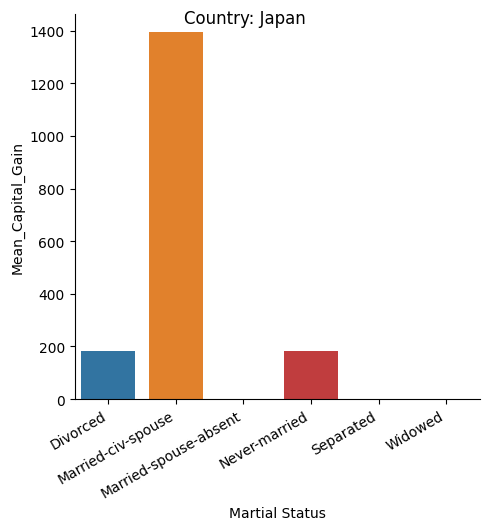

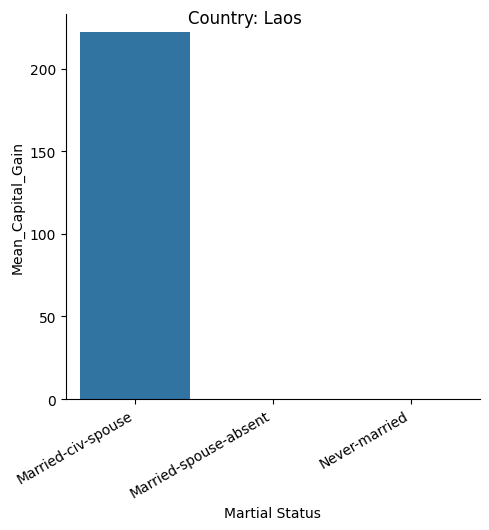

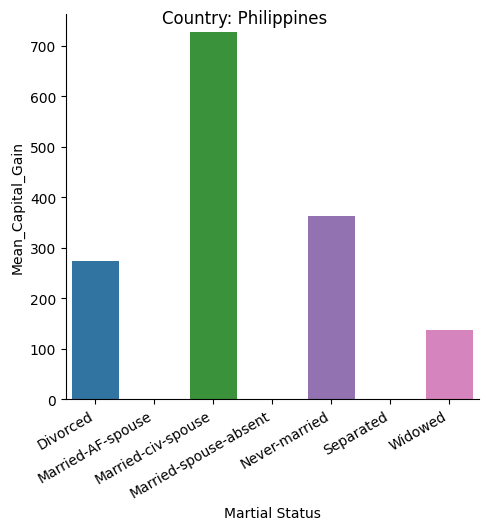

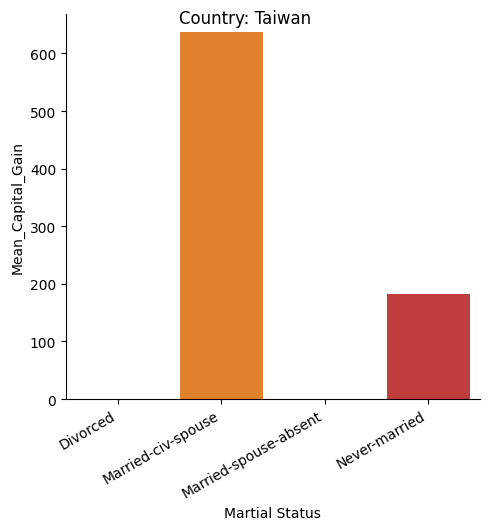

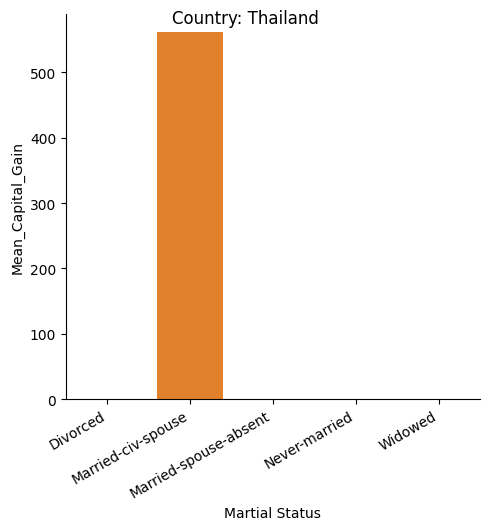

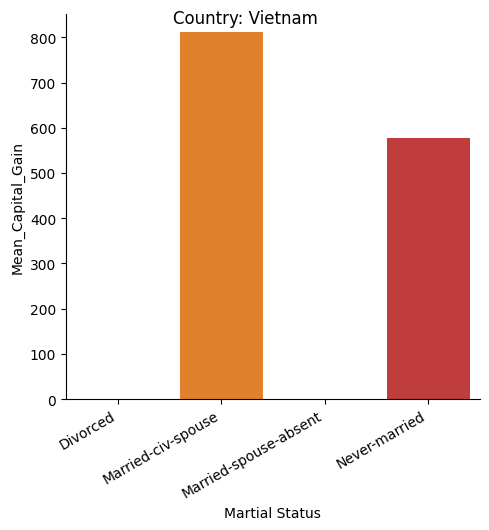

In [122]:
Mean_TotCapital_VS_Marital_Status('Asia', agg_df)

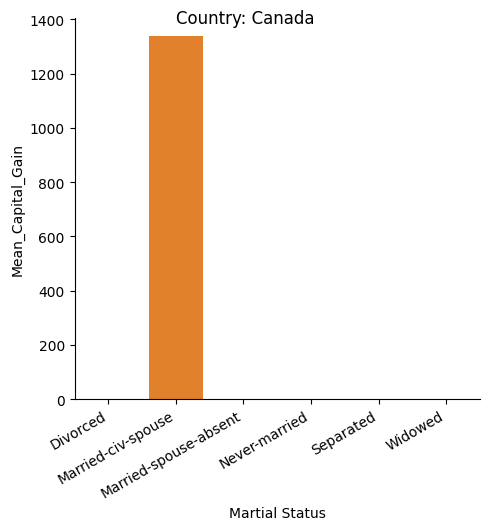

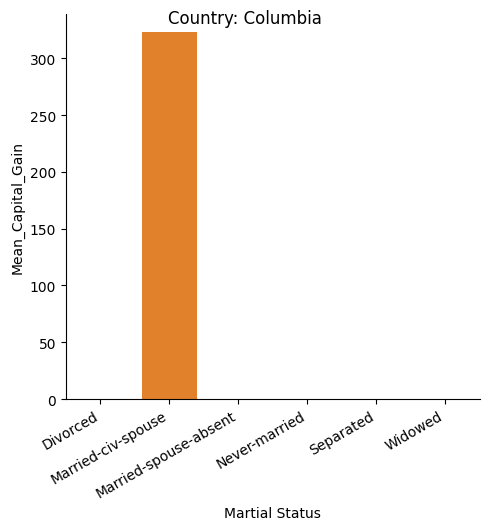

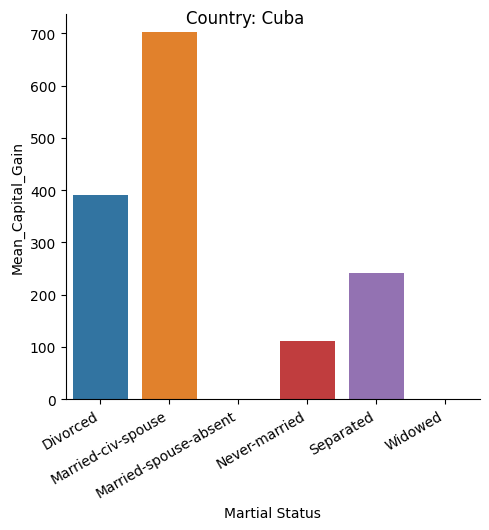

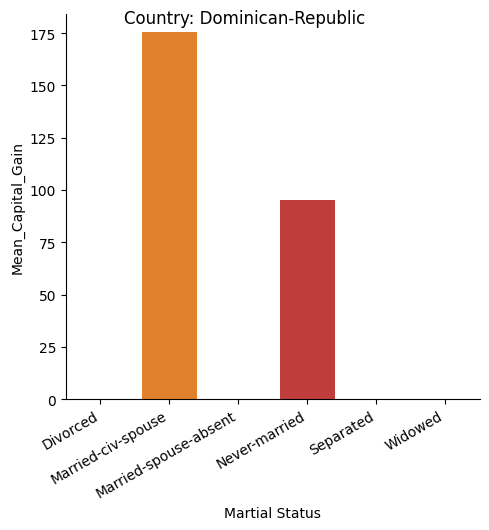

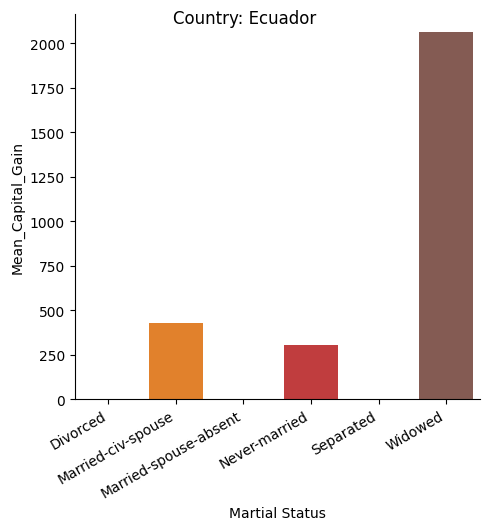

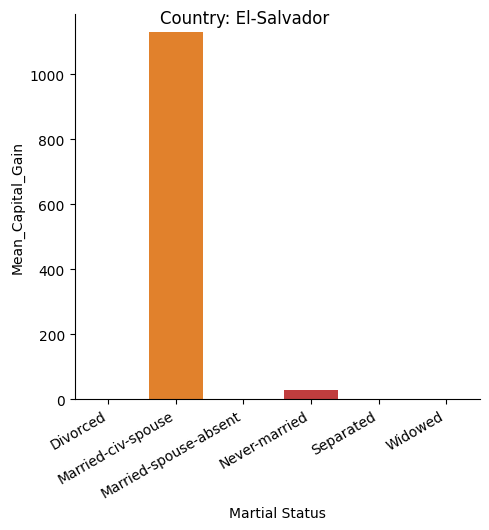

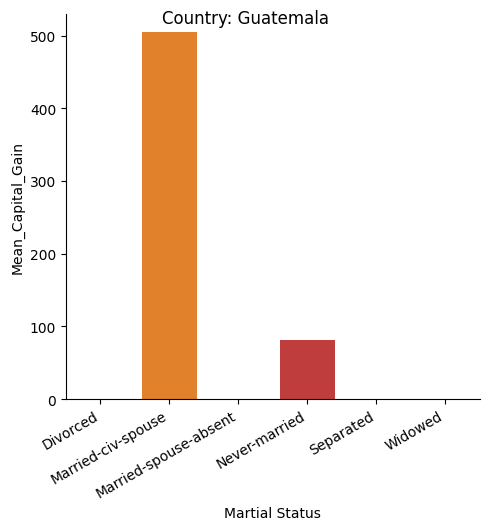

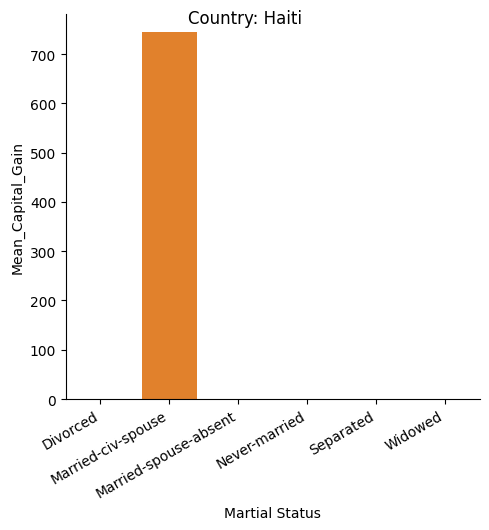

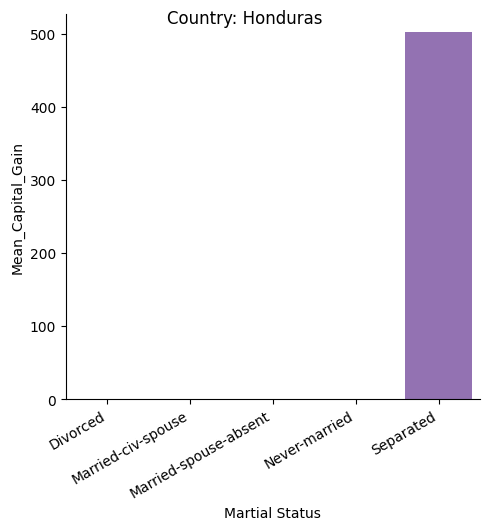

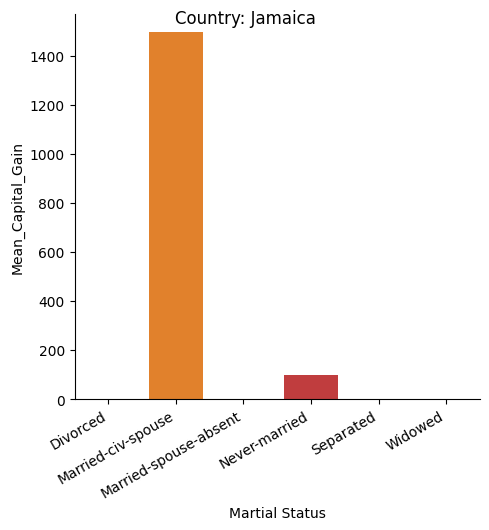

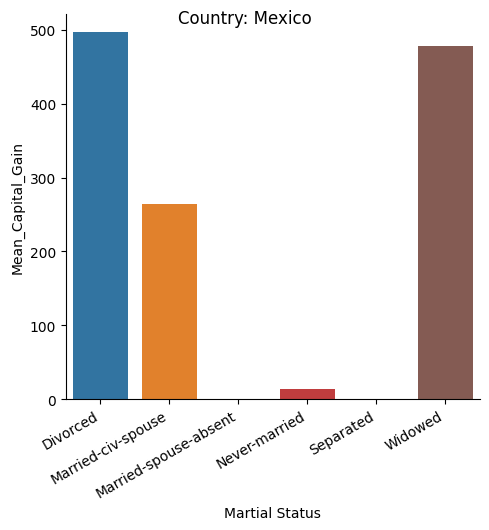

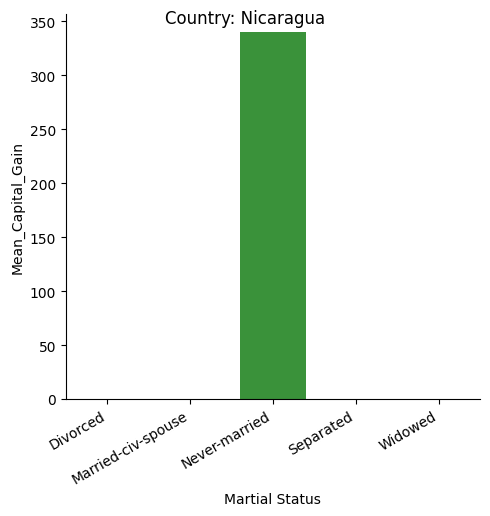

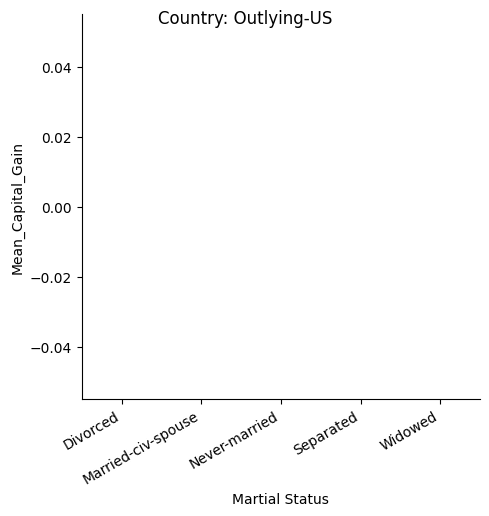

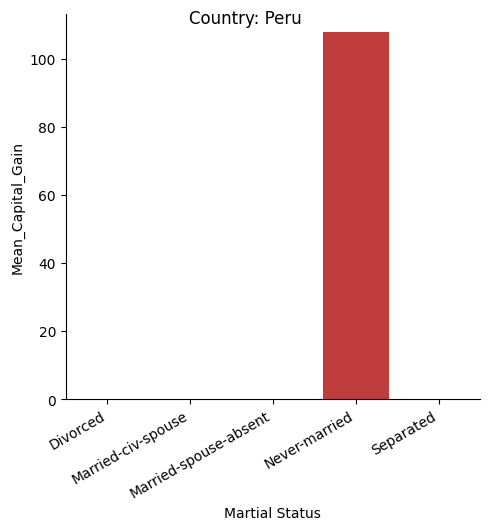

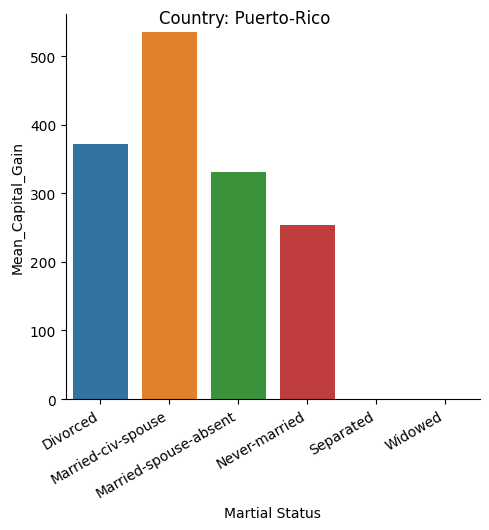

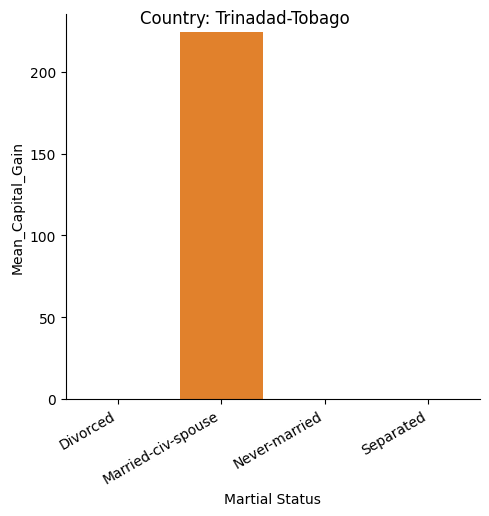

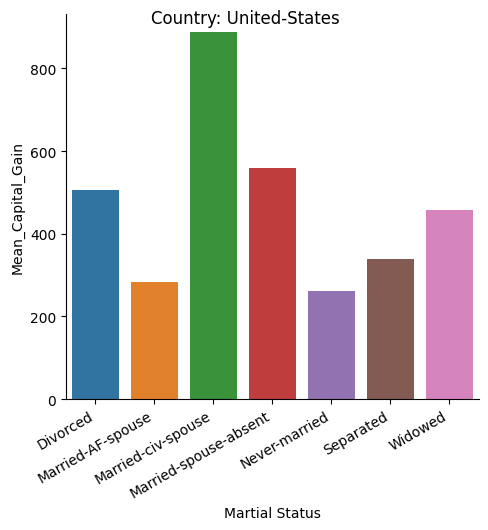

In [124]:
Mean_TotCapital_VS_Marital_Status('America', agg_df)

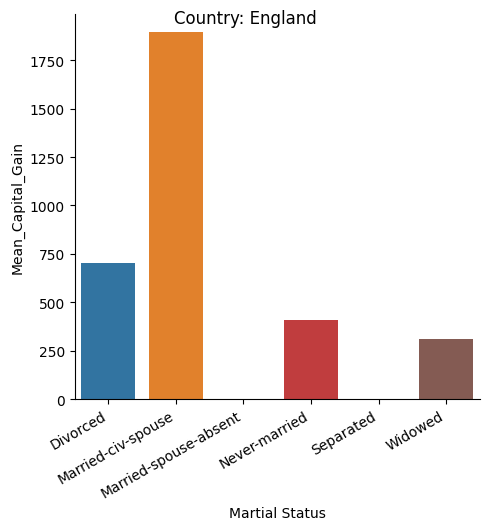

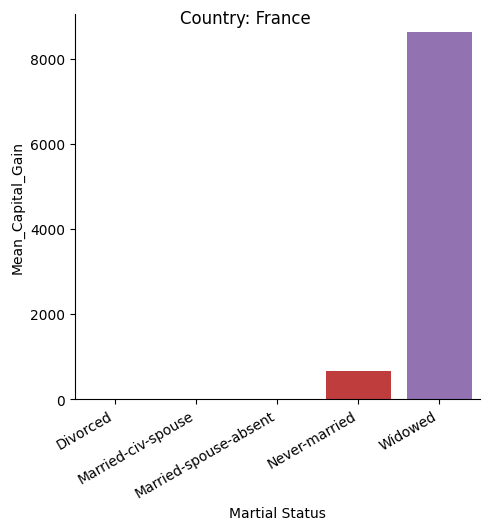

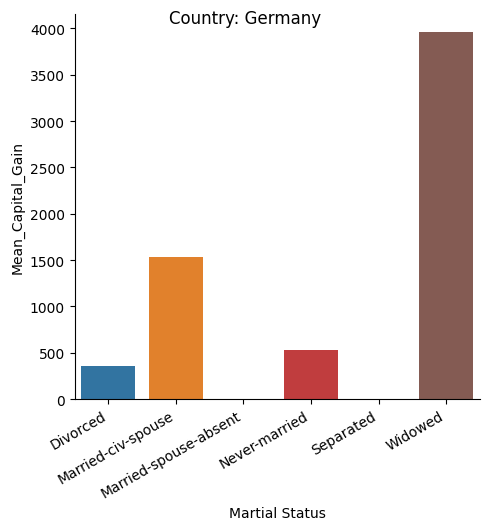

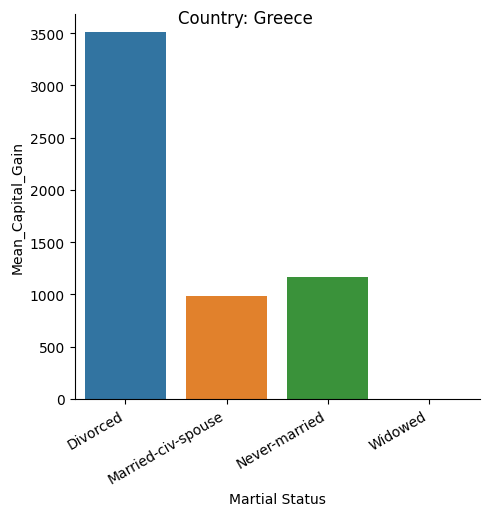

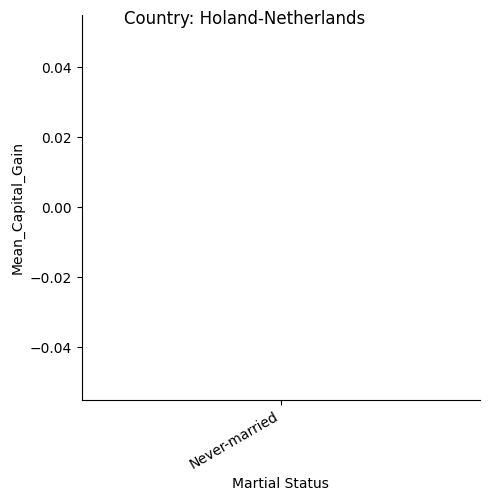

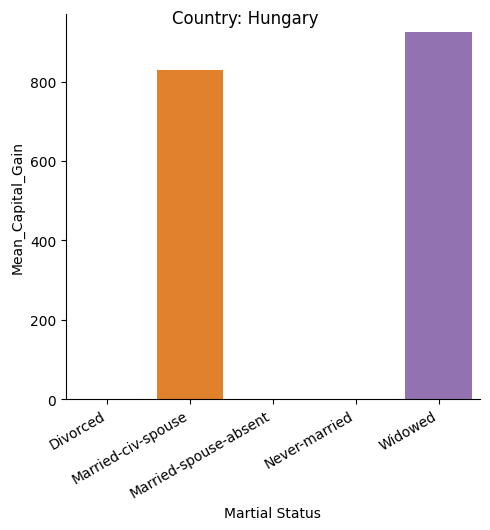

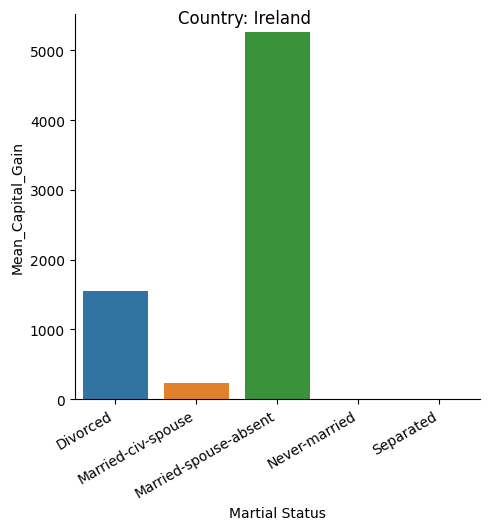

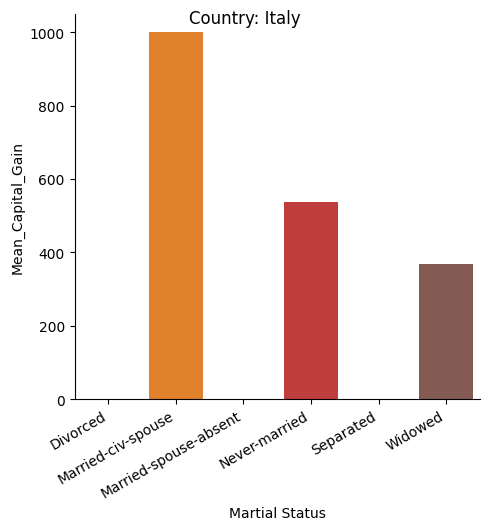

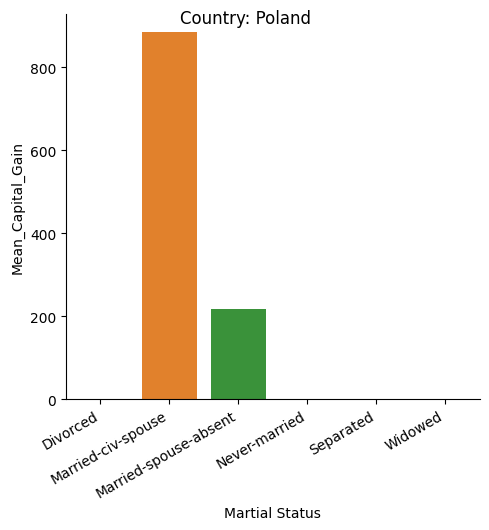

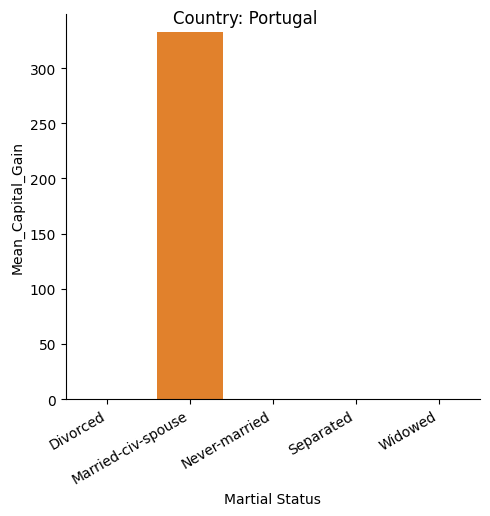

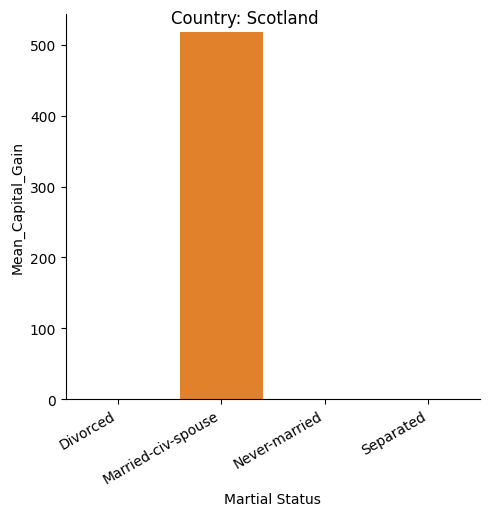

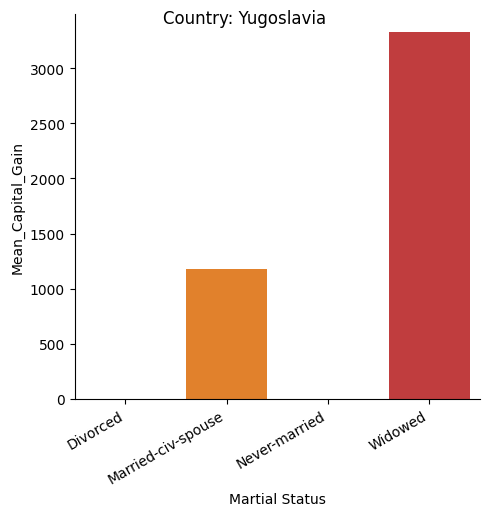

In [125]:
Mean_TotCapital_VS_Marital_Status('Europe', agg_df)

## Feature Engineering

This is one of the most crucial aspect for a Data Science project. It is a process of transforming the raw data to better representative features in order to create better predictive models.

In [126]:
edu = df_no_outliers.Education.unique()
eduNum = df_no_outliers['Education-Num'].unique()
print('Education: \nTotal category:{}\nValues: {}\n'.format(len(edu),list(edu)))
print('Education Num: \nTotal Education-Num:{}\nValues: {}'.format(len(eduNum),
                                                                  list(eduNum)))

Education: 
Total category:16
Values: ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']

Education Num: 
Total Education-Num:16
Values: [13, 9, 7, 14, 5, 10, 12, 11, 4, 16, 15, 3, 6, 2, 1, 8]


We can see that The Education-Num seems to be the numerical representation of Education, and also the same Total number (16). To do so, we will need only one of them, not both columns.
Let's check some observations (rows) to verify our hypothesis if there is a corrrespondance between Education-Num and Education.

Then we can simply visualize the two columns in order to check the correspondance between them.

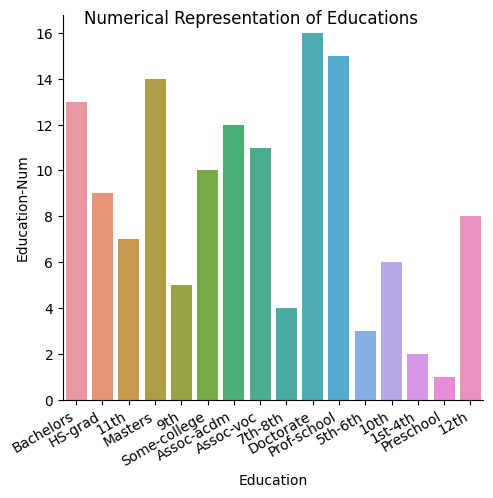

In [128]:
ax = sns.catplot(x='Education', y='Education-Num', kind='bar', data=df_no_outliers)
ax.figure.suptitle('Numerical Representation of Educations')
ax.figure.autofmt_xdate()

From the previous plot, we can see that

- Bachelor <==> 13
- HS-grad <==> 9
- 7th-8th <==> 4
- 9th <==> 5
- Preschool <==> 1
- etc.

Based on those information, we will need only one column to represent the level of education, and in our case,
we will choose Education-Num (remove Education column) which corresponds to the numerical representation.

In [129]:
# Finally remove the Education column  
df_no_outliers.drop('Education', axis=1, inplace=True)

Capital-Loss and Capital-Gain

From those two features, we can create a new column called Capital-State that will be the difference between Capital-Gain and Capital-Loss.

Then we will remove those two features

In [130]:
df_no_outliers['Capital-State'] = df_no_outliers['Capital-Gain'] - df_no_outliers['Capital-Loss']

In [131]:
# Then remove Capital-Gain and Capital-Loss. 
df_no_outliers.drop(['Capital-Gain', 'Capital-Loss'], axis=1, inplace=True)

Let's not forget to remove the column Continent

In [132]:
df_no_outliers.drop('Continent', axis=1, inplace=True)

Now let's change the variable age and divided it into two, child and adult, for this we will limit the age to 18 years old.

In [134]:
df_no_outliers['AgeState'] = np.where(df_no_outliers['Age'] >= 18, 'Adult', 'Child')
df_no_outliers['AgeState'].value_counts()

AgeState
Adult    47813
Child      591
Name: count, dtype: int64

In [135]:
# Remove this column because is not an important feature
df_no_outliers.drop('fnlwgt', axis=1, inplace=True)

In [136]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48404 entries, 0 to 16280
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48404 non-null  int64 
 1   Workclass       48404 non-null  object
 2   Education-Num   48404 non-null  int64 
 3   Martial Status  48404 non-null  object
 4   Occupation      48404 non-null  object
 5   Relationship    48404 non-null  object
 6   Race            48404 non-null  object
 7   Sex             48404 non-null  object
 8   Hours-per-week  48404 non-null  int64 
 9   Country         48404 non-null  object
 10  Income          48404 non-null  object
 11  Capital-State   48404 non-null  int64 
 12  AgeState        48404 non-null  object
dtypes: int64(4), object(9)
memory usage: 5.2+ MB


### Categorical Feature Encoding

A machine learning model only works with numerical features. To do so, we need to encode all our categorical features. Those features are represented by object with the help of the previous info command.

We are going to perform the One Hot Ending method on all the categorical features by using Pandas get_dummies() function.

We are not going to take in consideration Income column, because it is the column we try to predict.

In [137]:
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['Workclass', 'Martial Status', 'Occupation', 
                                 'Relationship', 'Race', 'Sex', 'Country', 'AgeState'])

In [138]:
df_no_outliers['Income'].unique()

array(['<=50K', '>50K'], dtype=object)

Now let's divide this variable into two, for those who make more than 50k and those who make less than 50k a year

In [139]:
df_no_outliers['Income'] = np.where(df_no_outliers['Income'] =='>50K', 1, 0)

- 1 for those who make more than 50k
- 0 for those who don't

In [141]:
columns = [column for column in df_no_outliers.columns if column != 'Income']
columns = columns + ['Income'] 
df = df_no_outliers[columns]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48404 entries, 0 to 16280
Data columns (total 89 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   Age                                   48404 non-null  int64
 1   Education-Num                         48404 non-null  int64
 2   Hours-per-week                        48404 non-null  int64
 3   Capital-State                         48404 non-null  int64
 4   Workclass_Federal-gov                 48404 non-null  bool 
 5   Workclass_Local-gov                   48404 non-null  bool 
 6   Workclass_Never-worked                48404 non-null  bool 
 7   Workclass_Private                     48404 non-null  bool 
 8   Workclass_Self-emp-inc                48404 non-null  bool 
 9   Workclass_Self-emp-not-inc            48404 non-null  bool 
 10  Workclass_State-gov                   48404 non-null  bool 
 11  Workclass_Without-pay                 48404 no

We put Income as the last column for the model part later

## Preparation, Models and Evaluation

Data Preparation

- We need to split our dataset for training and testing data.
- 80% of the data will be used for training and 20% for testing.

In [145]:
y = df['Income'].values.ravel()  # Target variable
X = df.drop('Income', axis=1).values  # Feature matrix

In [146]:
print('X shape: {} | y shape: {}'.format(X.shape, y.shape))

X shape: (48404, 88) | y shape: (48404,)


In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('X train shape: {} | y shape: {}'.format(X_train.shape, y_train.shape))
print('X test shape: {} | y shape: {}'.format(X_test.shape, y_test.shape))

X train shape: (38723, 88) | y shape: (38723,)
X test shape: (9681, 88) | y shape: (9681,)


In [152]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='most_frequent')

In [153]:
print('Score of baseline model : {0:.2f}'.format(dummy_clf.score(X_test, y_test)))

Score of baseline model : 0.51


In [155]:
lr_clf = LogisticRegression(random_state=0)
parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty' : ['l1','l2']}
lr_clf = GridSearchCV(lr_clf, param_grid=parameters, cv=3)

lr_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1.0, 10.0, 50.0, 100.0, 1000.0],
                         'penalty': ['l1', 'l2']})

In [156]:
lr_clf.best_params_

{'C': 1000.0, 'penalty': 'l2'}

In [157]:
print('Best score : {0:.2f}'.format(lr_clf.best_score_))

Best score : 0.64


In [158]:
print('Score for logistic regression - on test : {0:.2f}'.format(lr_clf.score(X_test, y_test)))

Score for logistic regression - on test : 0.63
